**Dataset Features (559 rows):**

---

1. **Gender**: patient's gender (1: male; 0: female).
2. **Age**: patient's age (in years).
3. **Sleep Duration**: average daily sleep duration (in hours).
4. **Physical Activity Level**: level of physical activity (range: 30 to 90).
5. **BMI Category**: body mass index classification (0: Normal Weight, 1: Normal, 2: Overweight, 3: Obese).
6. **Blood Pressure**: systolic/diastolic blood pressure (in mmHg).
7. **Heart Rate**: resting heart rate (in beats per minute).
8. **Daily Steps**: number of steps taken daily.
9. **Person ID**: unique identifier for each individual.
10. **Occupation**: patient job type (e.g., 0: unemployed, 1: student, 2: manual labor, 3: office worker, 4: professional).
11. **Quality of Sleep**: subjective rating of sleep quality (range: 4 to 9).
12. **Stress Level**: self-reported stress level (range: 3 to 8).

---

13. **Sleep Disorder**: whether the patient has a sleep disorder (0: None, 1: Sleep Apnea, 2: Insomnia).

**1. Import Libraries**

In [125]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from imblearn.over_sampling import SMOTE
from sklearn.ensemble import (
    RandomForestClassifier,
    VotingClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import QuantileTransformer, StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    ConfusionMatrixDisplay,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    balanced_accuracy_score,
    confusion_matrix
)
import tensorflow as tf

# Suppress the specific FutureWarning from Seaborn
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

data = pd.read_csv(r"..Sleep Apnea and Insomnia\Sleep Data.csv", keep_default_na=False)

**2. EDA - Exploratory Data Analysis**

###**2.1 General**

In [126]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 559 entries, 0 to 558
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gender                   559 non-null    object 
 1   Age                      559 non-null    int64  
 2   Sleep Duration           559 non-null    float64
 3   Physical Activity Level  559 non-null    int64  
 4   BMI Category             559 non-null    object 
 5   Blood Pressure           559 non-null    object 
 6   Heart Rate               559 non-null    int64  
 7   Daily Steps              559 non-null    int64  
 8   Sleep Disorder           559 non-null    object 
 9   Person ID                559 non-null    int64  
 10  Occupation               559 non-null    object 
 11  Quality of Sleep         559 non-null    int64  
 12  Stress Level             559 non-null    int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 56.9+ KB


In [127]:
#Check if there are duplicate values.
data = data.drop_duplicates()
data.duplicated().sum()

0

In [128]:
data_vis = data.copy()

In [129]:
data.head()

,Gender,Age,Sleep Duration,Physical Activity Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder,Person ID,Occupation,Quality of Sleep,Stress Level
0,Male,27,6.1,42,Overweight,126/83,77,4200,None,1,Software Engineer,6,6
1,Male,28,6.2,60,Normal,125/80,75,10000,None,2,Doctor,6,8
2,Male,28,6.2,60,Normal,125/80,75,10000,None,3,Doctor,6,8
3,Male,28,5.9,30,Obese,140/90,85,3000,Sleep Apnea,4,Sales Representative,4,8
4,Male,28,5.9,30,Obese,140/90,85,3000,Sleep Apnea,5,Sales Representative,4,8


In [130]:
# Rename 'Gender' to 'Sex' and map values
data.rename(columns={'Gender': 'sex', 'Age': 'age'}, inplace=True)
data['sex'] = data['sex'].map({'Male': 0, 'Female': 1})

# Rename 'BMI Category' to 'bmi' and map values
bmi_category_mapping = {
    'Normal': 25.0,
    'Normal Weight': 18.0,
    'Overweight': 27.5,
    'Obese': 32.5
}
data.rename(columns={'BMI Category': 'bmi'}, inplace=True)
data['bmi'] = data['bmi'].map(bmi_category_mapping)

# Split 'Blood Pressure' into 'Systolic_Bp' and 'Dystolic_Bp'
data[['Systolic_Bp', 'Dystolic_Bp']] = data['Blood Pressure'].str.split('/', expand=True).astype(int)

# Drop the original columns
data.drop(columns=['Blood Pressure'], inplace=True)

# Display the transformed DataFrame
data.head()

,sex,age,Sleep Duration,Physical Activity Level,bmi,Heart Rate,Daily Steps,Sleep Disorder,Person ID,Occupation,Quality of Sleep,Stress Level,Systolic_Bp,Dystolic_Bp
0,0,27,6.1,42,27.5,77,4200,None,1,Software Engineer,6,6,126,83
1,0,28,6.2,60,25.0,75,10000,None,2,Doctor,6,8,125,80
2,0,28,6.2,60,25.0,75,10000,None,3,Doctor,6,8,125,80
3,0,28,5.9,30,32.5,85,3000,Sleep Apnea,4,Sales Representative,4,8,140,90
4,0,28,5.9,30,32.5,85,3000,Sleep Apnea,5,Sales Representative,4,8,140,90


In [131]:
data.describe()

,sex,age,Sleep Duration,Physical Activity Level,bmi,Heart Rate,Daily Steps,Person ID,Quality of Sleep,Stress Level,Systolic_Bp,Dystolic_Bp
count,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000,559.000000
mean,0.427549,39.987478,7.114132,58.758497,25.445438,70.182469,6820.751342,280.000000,7.271914,5.463327,126.967800,83.459750
std,0.495166,8.099616,0.742149,19.961450,2.500389,3.875617,1528.814803,161.513673,1.133293,1.674711,7.540027,5.760271
min,0.000000,27.000000,5.800000,30.000000,18.000000,65.000000,3000.000000,1.000000,4.000000,3.000000,115.000000,75.000000
25%,0.000000,33.000000,6.500000,45.000000,25.000000,68.000000,5500.000000,140.500000,6.000000,4.000000,120.000000,80.000000
50%,0.000000,38.000000,7.200000,60.000000,25.000000,70.000000,7000.000000,280.000000,7.000000,5.000000,128.000000,84.000000
75%,1.000000,44.000000,7.700000,75.000000,27.500000,72.000000,8000.000000,419.500000,8.000000,7.000000,130.000000,85.000000
max,1.000000,59.000000,8.500000,90.000000,32.500000,86.000000,10000.000000,559.000000,9.000000,8.000000,142.000000,95.000000


In [132]:
unique_values = {}
for col in data_vis.columns:
    unique_values[col] = data_vis[col].value_counts().shape[0]

pd.DataFrame(unique_values, index=['unique value count']).transpose()
data_vis

,Gender,Age,Sleep Duration,Physical Activity Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder,Person ID,Occupation,Quality of Sleep,Stress Level
0,Male,27,6.1,42,Overweight,126/83,77,4200,None,1,Software Engineer,6,6
1,Male,28,6.2,60,Normal,125/80,75,10000,None,2,Doctor,6,8
2,Male,28,6.2,60,Normal,125/80,75,10000,None,3,Doctor,6,8
3,Male,28,5.9,30,Obese,140/90,85,3000,Sleep Apnea,4,Sales Representative,4,8
4,Male,28,5.9,30,Obese,140/90,85,3000,Sleep Apnea,5,Sales Representative,4,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
554,Female,43,6.7,45,Overweight,135/90,65,6000,Insomnia,555,Teacher,7,4
555,Male,43,6.5,45,Overweight,130/85,72,6000,Insomnia,556,Salesperson,6,7
556,Female,43,6.7,45,Overweight,135/90,65,6000,Insomnia,557,Teacher,7,4
557,Male,43,6.4,45,Overweight,130/85,72,6000,Insomnia,558,Salesperson,6,7


1. The **"Occupation"** column will need One Hot Encoder to process as nominal categorical data.
2. The **"Age"** and **"BMI Category"** columns will be processed using Binning or Scaling.
3. **"Sleep Duration," "Physical Activity Level," "Blood Pressure," "Heart Rate," and "Daily Steps"** columns will be processed using Scaling to standardize continuous values.

###**2.2 Frequency of the value of the features in the dataset.**

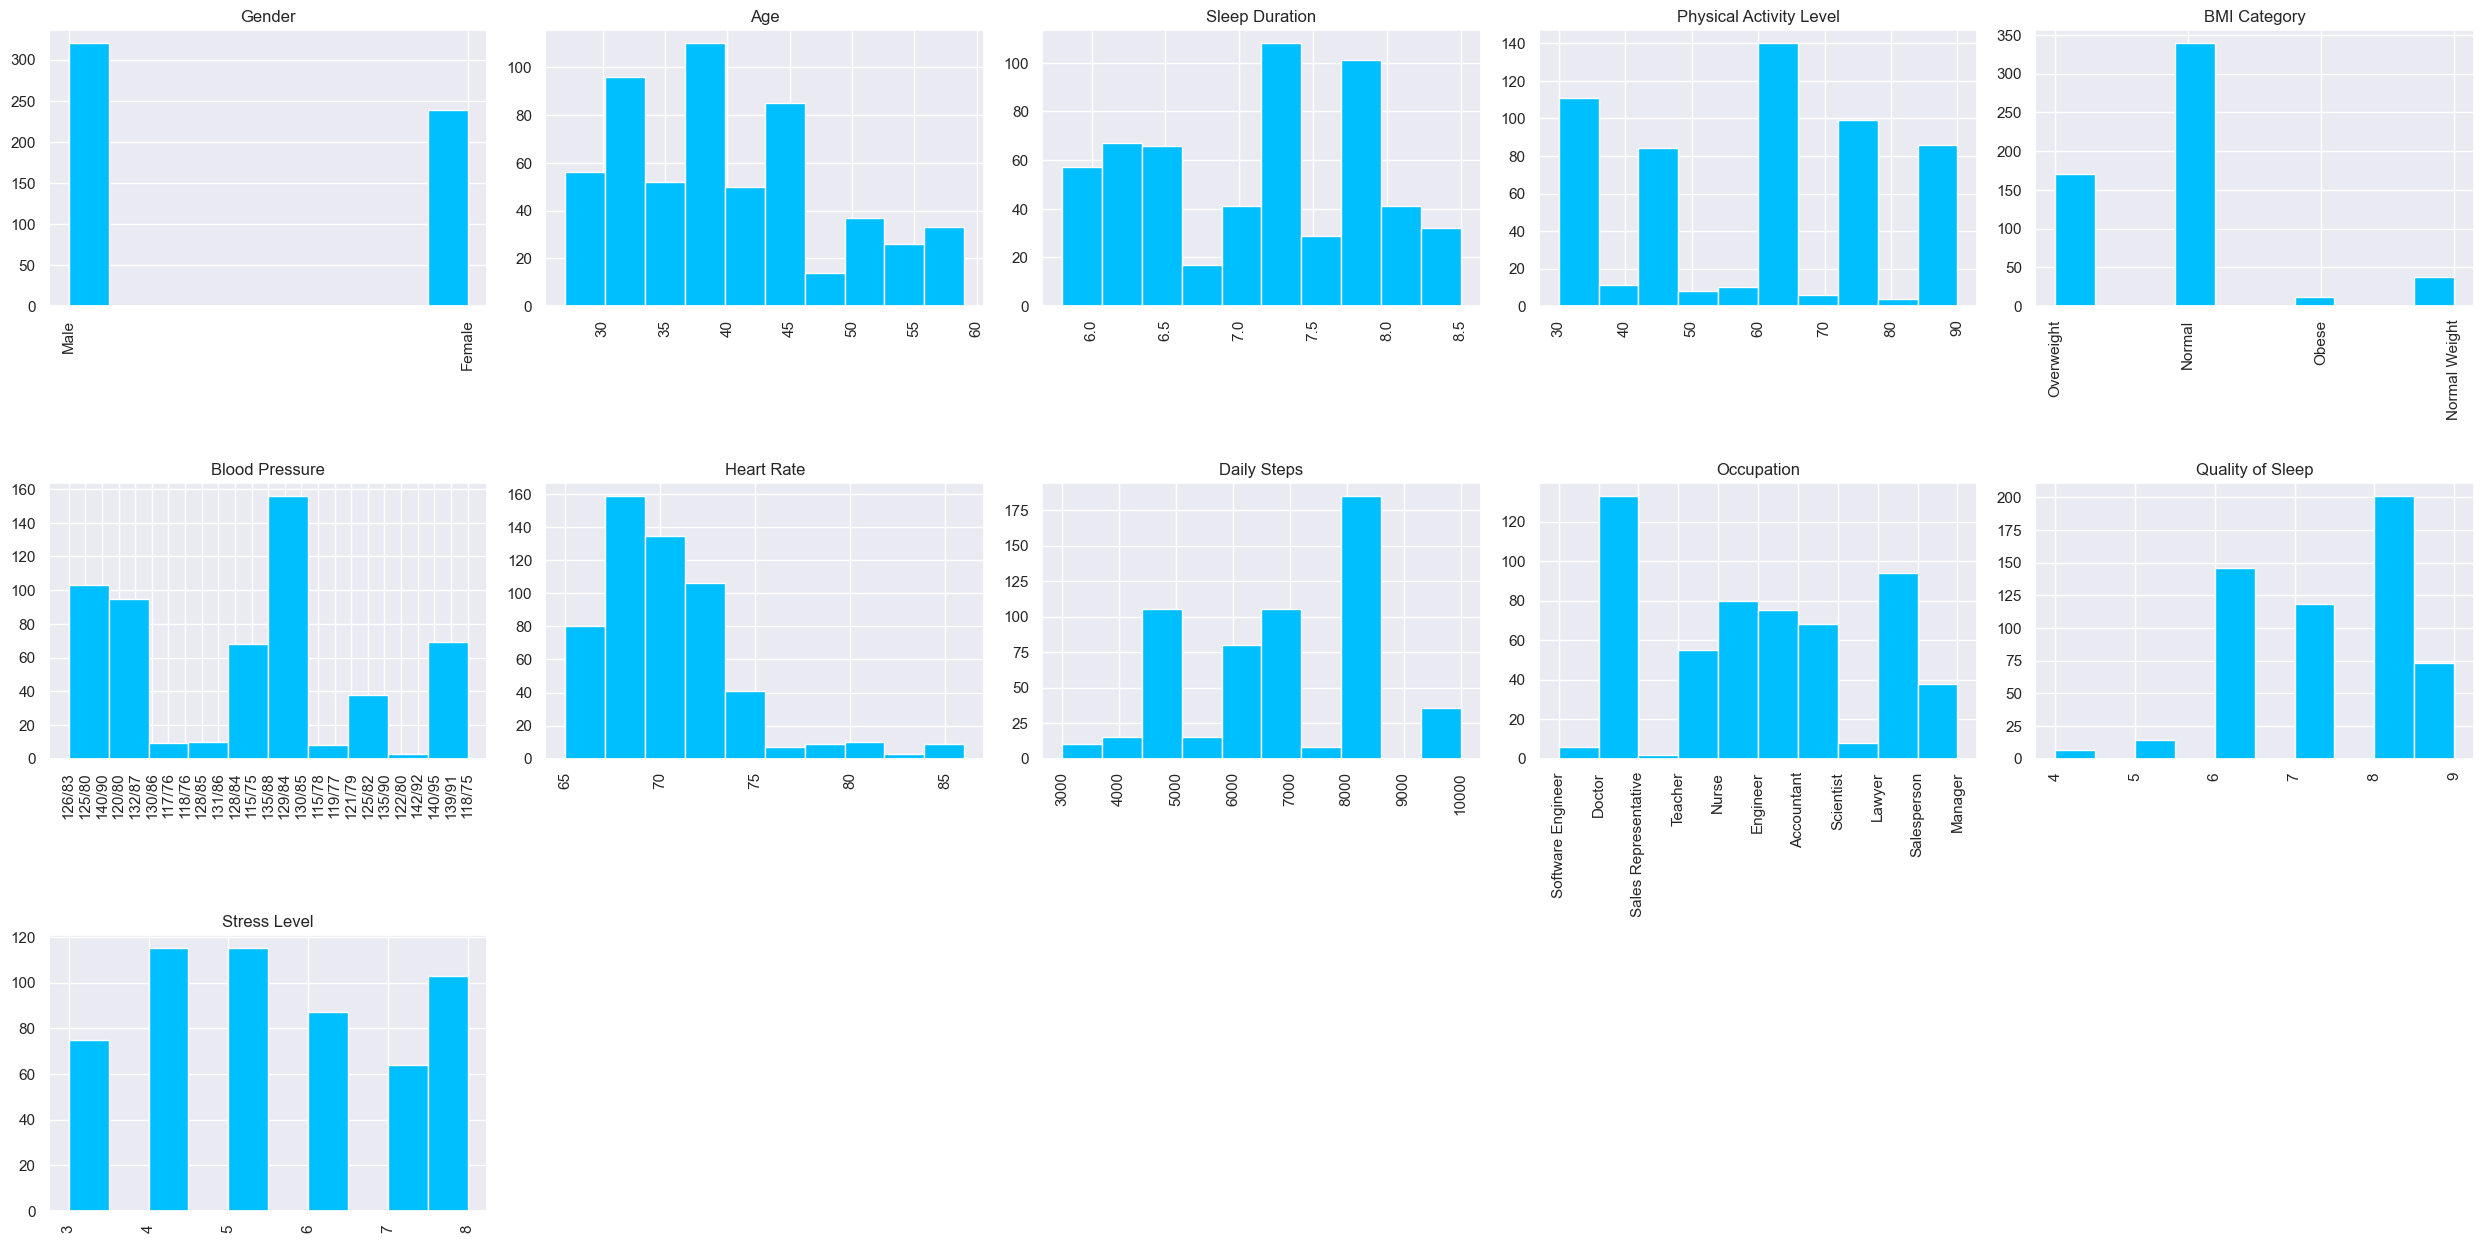

In [133]:
# All data columns except for Sleep Disorder and Person ID
feature_cols = [x for x in data_vis.columns if x not in ['Sleep Disorder', 'Person ID','Sleep Disorder Encoded']]
plt.figure(figsize=(25, 35))

# Loop for subplots
for i in range(len(feature_cols)):
    plt.subplot(8, 5, i + 1)
    plt.title(feature_cols[i])
    plt.xticks(rotation=90)
    plt.hist(data_vis[feature_cols[i]], color="deepskyblue")

plt.tight_layout()
plt.show()

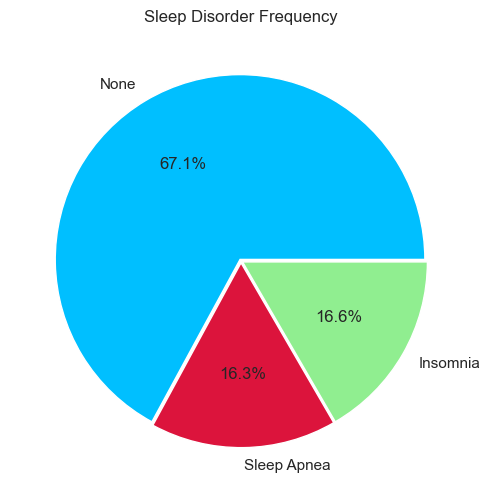

In [134]:
# Target values frequency for Sleep Disorder
plt.figure(figsize=(8, 6))
labels = ['None', 'Sleep Apnea', 'Insomnia']
sizes = [data_vis['Sleep Disorder'].value_counts()['None'], 
         data_vis['Sleep Disorder'].value_counts()['Sleep Apnea'], 
         data_vis['Sleep Disorder'].value_counts()['Insomnia']]
colors = ['deepskyblue', 'crimson', 'lightgreen']
explode = (0.01, 0.01, 0.01)  # explode all slices slightly
plt.pie(sizes, explode=explode, labels=labels, autopct='%.1f%%', colors=colors)

plt.title("Sleep Disorder Frequency")
plt.show()

Here there is a **"Class imbalance"** so I will use the hyperparameter **"Class weights = balanced"** during model training.

###**2.3 Correlation between each feature and Sleep disorder**

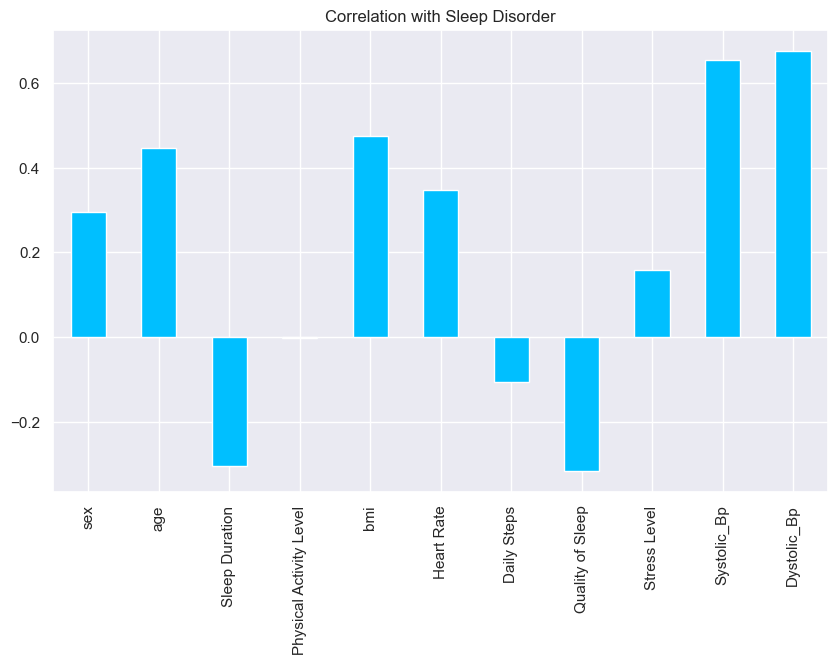

In [135]:
data_vis = data.copy()
# Encode the Sleep Disorder column
sleep_disorder_mapping = {
    'None': 0,
    'Sleep Apnea': 1,
    'Insomnia': 1
}
data_vis['Sleep Disorder'] = data_vis['Sleep Disorder'].replace(sleep_disorder_mapping)

# Drop the Occupation column
data_vis.drop(columns=['Occupation','Person ID'], inplace=True)

# Correlation with Sleep Disorder Encoded
data_vis.drop(['Sleep Disorder'], axis=1).corrwith(data_vis['Sleep Disorder']).plot(
    kind='bar', grid=True, figsize=(10, 6), title="Correlation with Sleep Disorder", color="deepskyblue"
)

# Show the plot
plt.show()

The features "Physical Activity Level", "Daily Steps"and "Stress Level" are least correlated with Sleep Disorder.
All other features have a significant correlation with Sleep Disorder.

###**2.4 Correlation between any two features**

<Axes: >

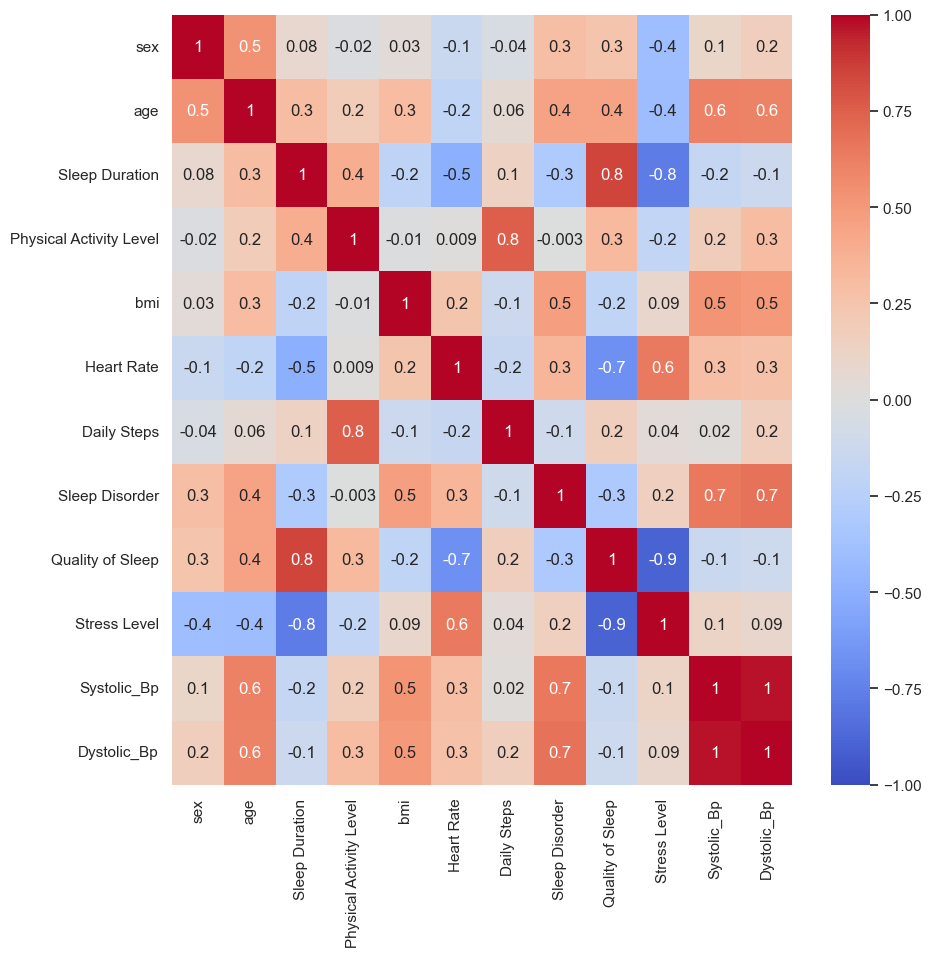

In [136]:
sns.set(rc = {'figure.figsize':(10,10)})
sns.heatmap(data_vis.corr(),vmin=-1, vmax=1, annot = True, fmt='.1g',cmap= 'coolwarm')

###**2.5 Sleep Disorder frequency by categorical and numeric features**

In [137]:
data.head()

,sex,age,Sleep Duration,Physical Activity Level,bmi,Heart Rate,Daily Steps,Sleep Disorder,Person ID,Occupation,Quality of Sleep,Stress Level,Systolic_Bp,Dystolic_Bp
0,0,27,6.1,42,27.5,77,4200,None,1,Software Engineer,6,6,126,83
1,0,28,6.2,60,25.0,75,10000,None,2,Doctor,6,8,125,80
2,0,28,6.2,60,25.0,75,10000,None,3,Doctor,6,8,125,80
3,0,28,5.9,30,32.5,85,3000,Sleep Apnea,4,Sales Representative,4,8,140,90
4,0,28,5.9,30,32.5,85,3000,Sleep Apnea,5,Sales Representative,4,8,140,90


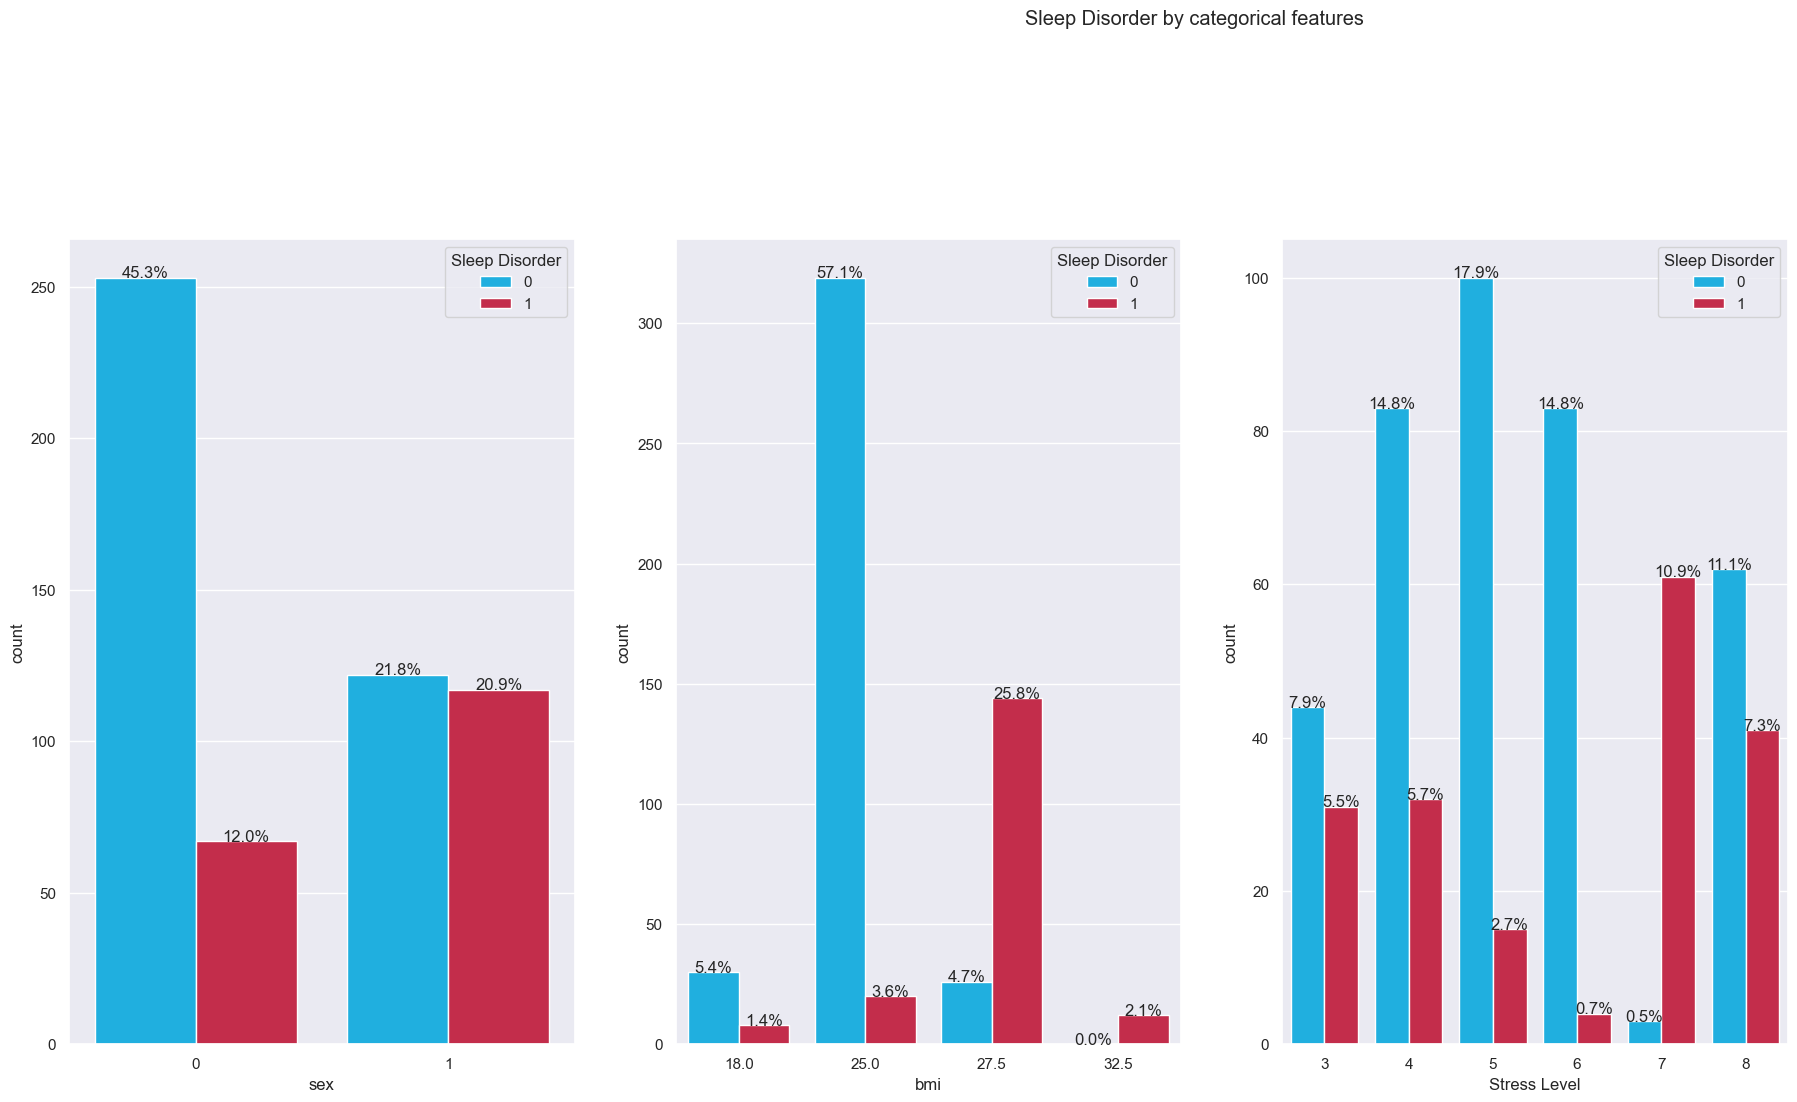

In [138]:
features = [x for x in data.columns if x not in ['Sleep Disorder','age','Person ID','Sleep Duration','Physical Activity Level','Occupation','Quality of Sleep','Systolic_Bp','Dystolic_Bp', 'Heart Rate', 'Daily Steps']]
plt.figure(figsize=(30,23))
plt.suptitle('Sleep Disorder by categorical features')

# Subplots
for index, feature in enumerate(features):
    plt.subplot(2, 4, index + 1)
    ax = sns.countplot(x=feature, hue='Sleep Disorder', data=data_vis, palette=['deepskyblue', 'crimson'])
    plt.xlabel(feature)

    # Annotating the percentages
    total_count = len(data_vis)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2., height + 0.01, '{:.1f}%'.format((height / total_count) * 100),
                ha="center")
        
plt.show()


* Females are more likely to have sleep disorders
* People with more bmi are likely to have sleep disorders
* Stress levels have no effect on sleep disorder

In [139]:
#scale the data before pairplot
data_pairplot = data.copy()
float_columns = [x for x in data.columns if x in ['age', 'Sleep Duration', 'Physical Activity Level', 'bmi',
       'Heart Rate', 'Daily Steps', 'Quality of Sleep', 'Stress Level']]

sc = StandardScaler()
data_pairplot[float_columns] = sc.fit_transform(data_pairplot[float_columns])
data_pairplot.head(4)

,sex,age,Sleep Duration,Physical Activity Level,bmi,Heart Rate,Daily Steps,Sleep Disorder,Person ID,Occupation,Quality of Sleep,Stress Level,Systolic_Bp,Dystolic_Bp
0,0,-1.604904,-1.367704,-0.840295,0.822433,1.760658,-1.715773,None,1,Software Engineer,-1.123322,0.320744,126,83
1,0,-1.481331,-1.232840,0.062251,-0.178307,1.244149,2.081414,None,2,Doctor,-1.123322,1.516050,125,80
2,0,-1.481331,-1.232840,0.062251,-0.178307,1.244149,2.081414,None,3,Doctor,-1.123322,1.516050,125,80
3,0,-1.481331,-1.637433,-1.441992,2.823912,3.826694,-2.501397,Sleep Apnea,4,Sales Representative,-2.889672,1.516050,140,90


In [140]:
data_pairplot['Sleep Disorder'] = data_pairplot['Sleep Disorder'].map({
    'None': 0,  # No sleep disorder
    'Sleep Apnea': 1,  # Sleep Apnea disorder
    'Insomnia': 1  # Insomnia disorder
})

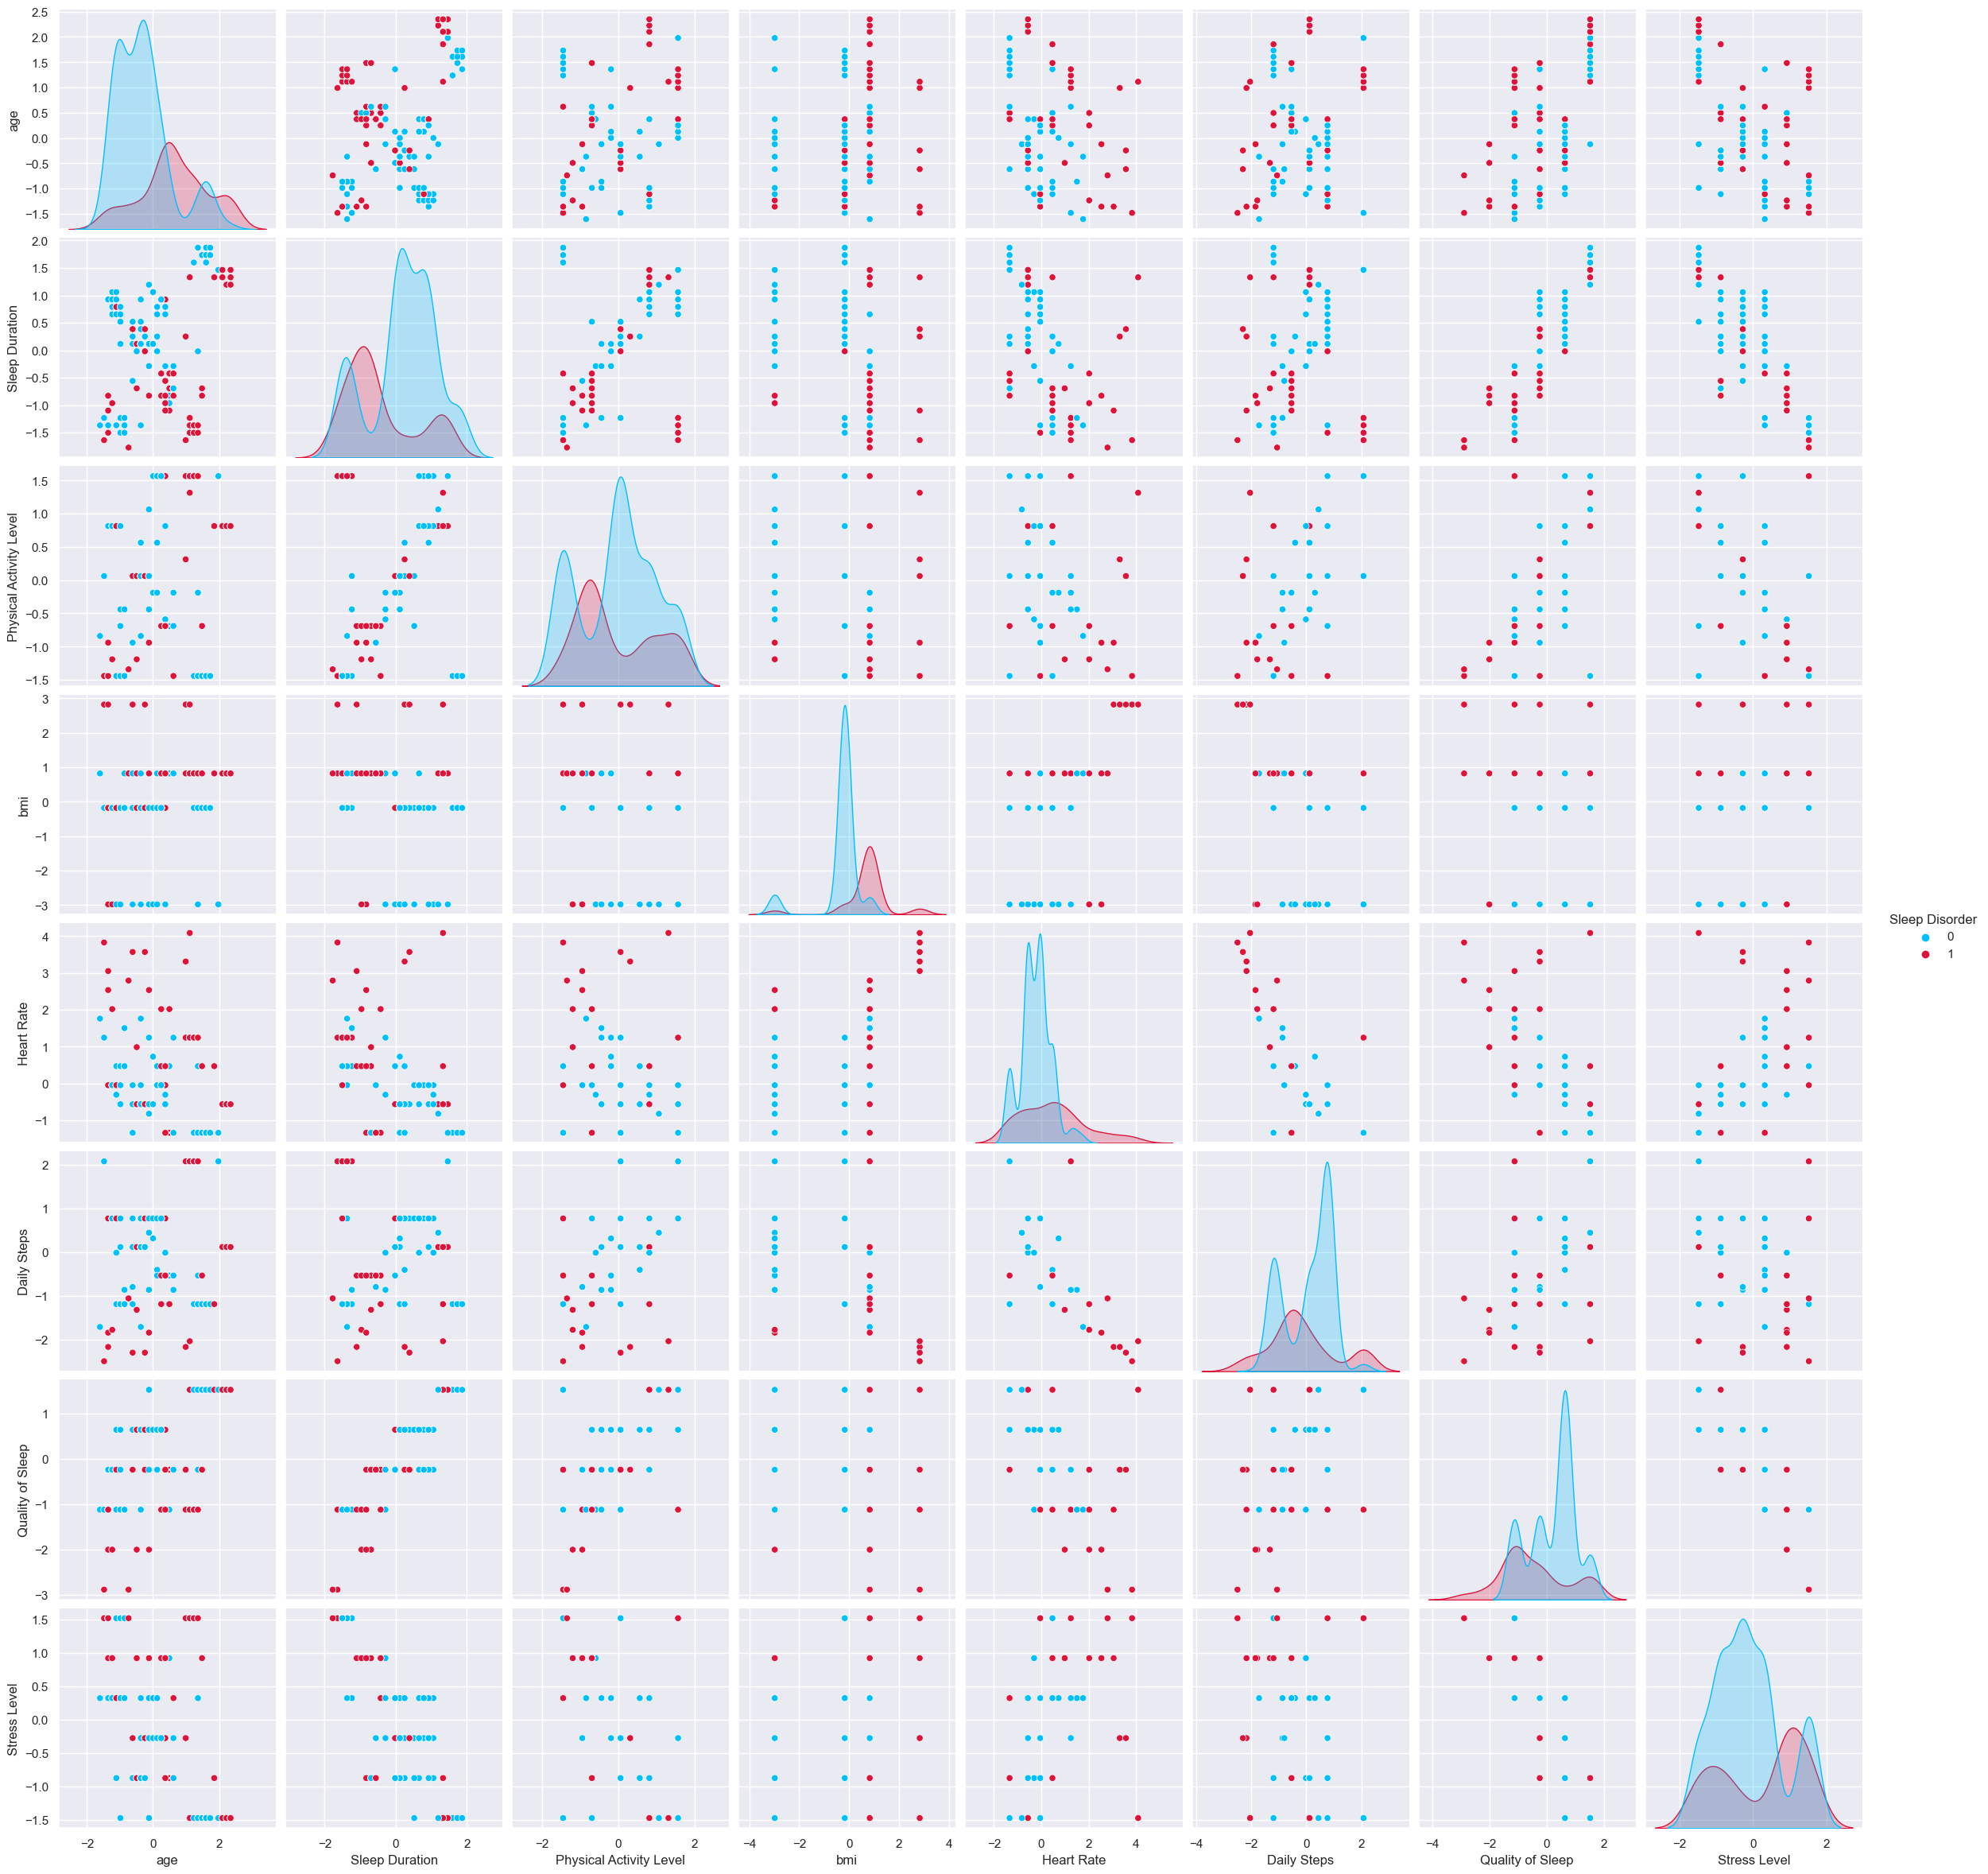

In [141]:
# Replace infinite values with NaN
data_pairplot.replace([np.inf, -np.inf], np.nan, inplace=True)

# List of numerical columns to be included in the pairplot
float_columns = ['age', 'Sleep Duration', 'Physical Activity Level', 'bmi',
                 'Heart Rate', 'Daily Steps', 'Quality of Sleep', 'Stress Level']

# Set the context for plotting
sns.set_context('notebook')

# Create the pairplot with hue as 'Sleep Disorder'
sns.pairplot(data_pairplot[float_columns + ['Sleep Disorder']], 
             hue='Sleep Disorder', 
             hue_order=[0, 1],
             height=3,
             palette={0: 'deepskyblue', 1: 'crimson'})

###**2.6 The effect of combining categorical features on Sleep Disorder**

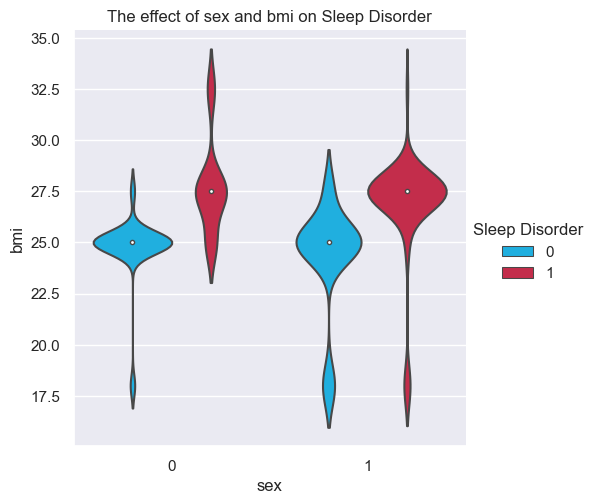

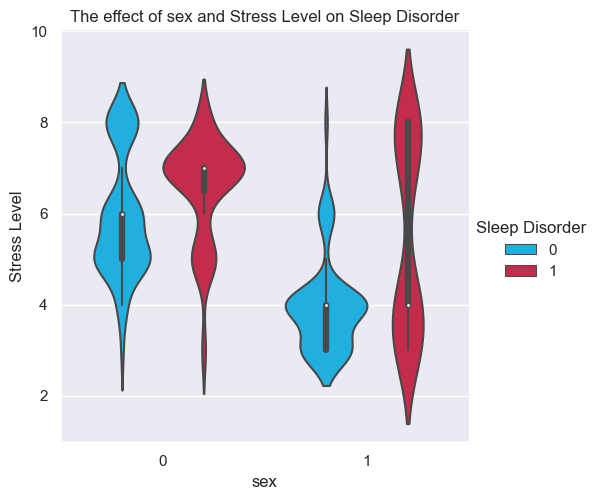

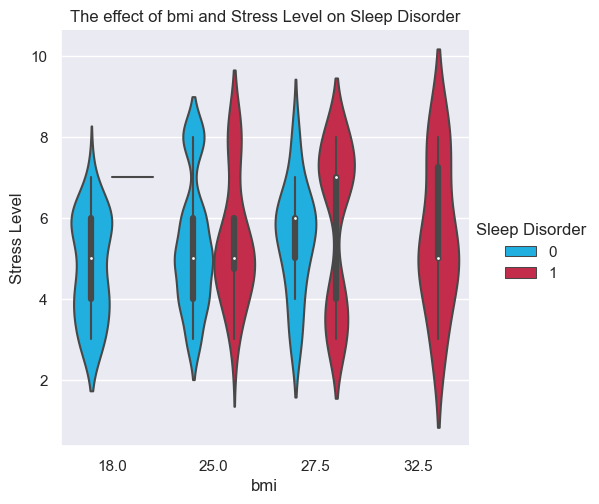

In [142]:
data_com = data.copy()
data_com['Sleep Disorder'] = data['Sleep Disorder'].map({
    'None': 0,  # No sleep disorder
    'Sleep Apnea': 1,  # Sleep Apnea disorder
    'Insomnia': 1  # Insomnia disorder
})

for i in range (len(features)):
    for x in range (len(features)-i-1):
        sns.catplot(data=data_com, x=features[i], y=features[i+x+1], hue="Sleep Disorder", kind="violin",palette = ['deepskyblue','crimson']).set(title="The effect of "+features[i] + " and "+features[i+x+1]+" on Sleep Disorder")

###**2.7 Numeric features distributions**

**Age**

<Figure size 1200x500 with 0 Axes>

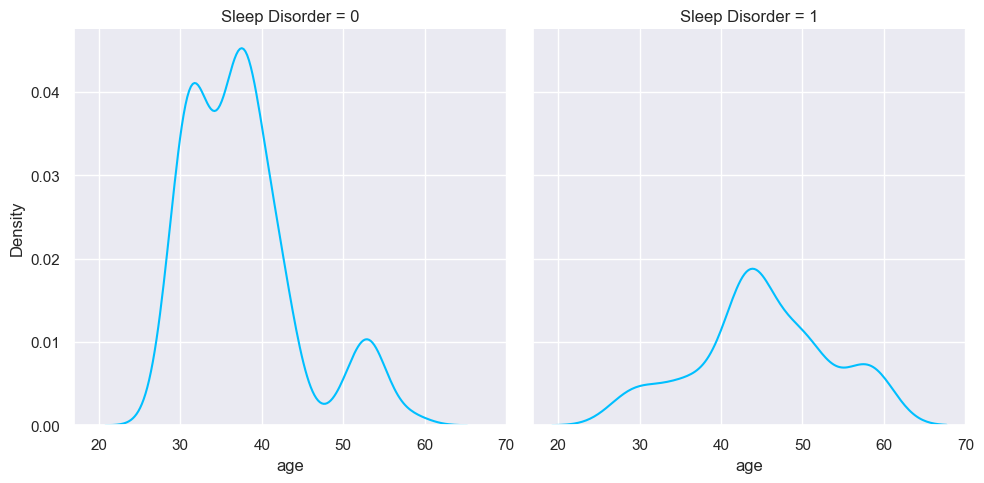

In [143]:
plt.figure(figsize=(12,5))
sns.displot(x='age', col='Sleep Disorder' , data = data_vis, kind="kde" ,color = 'deepskyblue');

In [144]:
# Adjust the bins and labels to match the maximum age
bins = [0, 30, 45, 55, max(data['age']) + 1]  # Ensure the last bin includes the max age
labels = ['0-30', '30-45', '45-55', '55+']    # Adjust labels to match the bins

# Categorize the 'age' column into bins
age = pd.cut(data['age'], bins=bins, labels=labels, right=False)

# Create the crosstab and convert it to float
age_temp = pd.crosstab(data['Sleep Disorder'], age, rownames=['Sleep Disorder']).astype(float)
age_temp

age,0-30,30-45,45-55,55+
Sleep Disorder,,,,
Insomnia,4.0,68.0,21.0,0.0
None,20.0,313.0,37.0,5.0
Sleep Apnea,6.0,24.0,31.0,30.0


<Figure size 1000x600 with 0 Axes>

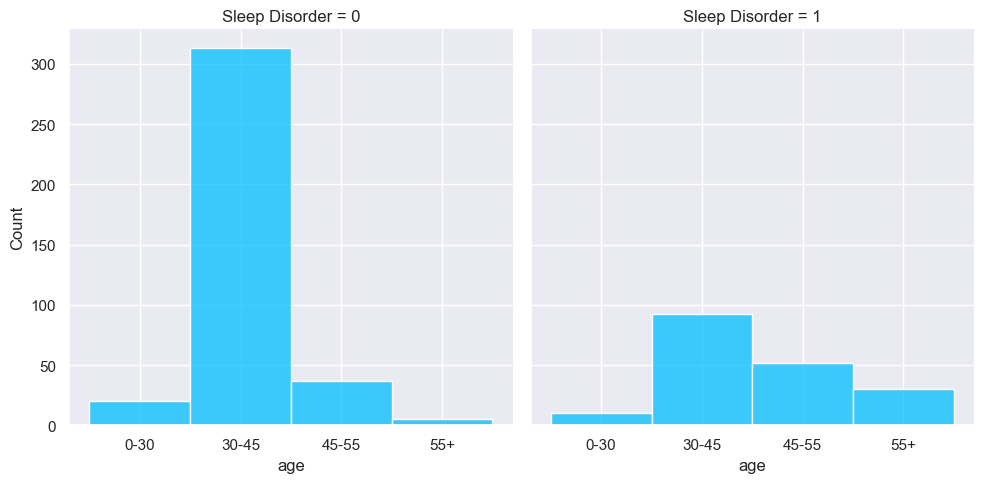

In [145]:
plt.figure(figsize=(10,6))
sns.displot(data=data_vis,col='Sleep Disorder',x=age,color='deepskyblue');

**Sleep Duration**

<Figure size 1200x500 with 0 Axes>

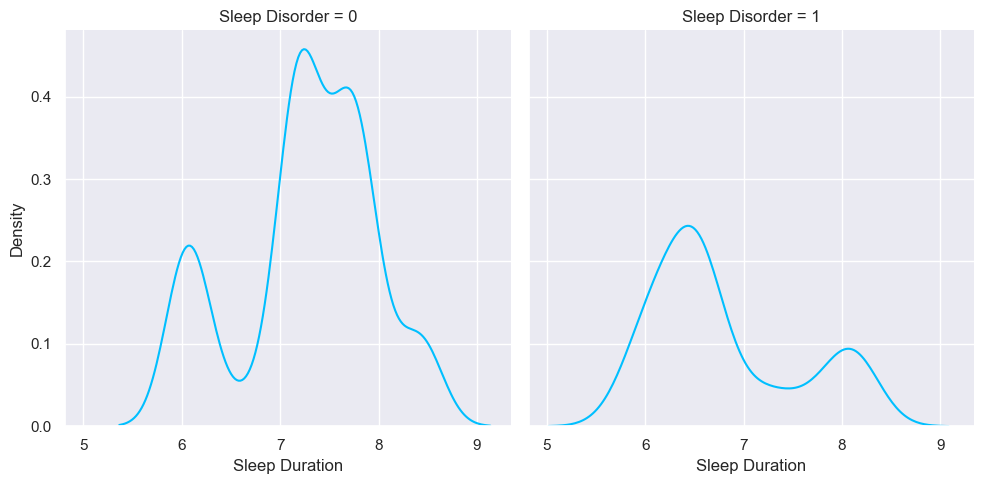

In [146]:
plt.figure(figsize=(12,5))
sns.displot(x='Sleep Duration', col='Sleep Disorder' , data = data_vis, kind="kde" ,color = 'deepskyblue');

In [147]:
# Define the bins and labels based on max sleep duration
bins = [0, 5, 6, 7, 8, max(data['Sleep Duration']) + 0.5]  # Add a small buffer to include max duration
labels = ['<5', '5-6', '6-7', '7-8', '8+']                # Update labels accordingly

# Categorize the 'Sleep Duration' column into bins
sleep_duration = pd.cut(data['Sleep Duration'], bins=bins, labels=labels, right=False)

# Create the crosstab and convert it to float
sleep_temp = pd.crosstab(data['Sleep Disorder'], sleep_duration, rownames=['Sleep Disorder']).astype(float)
sleep_temp

Sleep Duration,5-6,6-7,7-8,8+
Sleep Disorder,,,,
Insomnia,1.0,81.0,10.0,1.0
None,0.0,81.0,254.0,40.0
Sleep Apnea,7.0,41.0,11.0,32.0


<Figure size 1000x600 with 0 Axes>

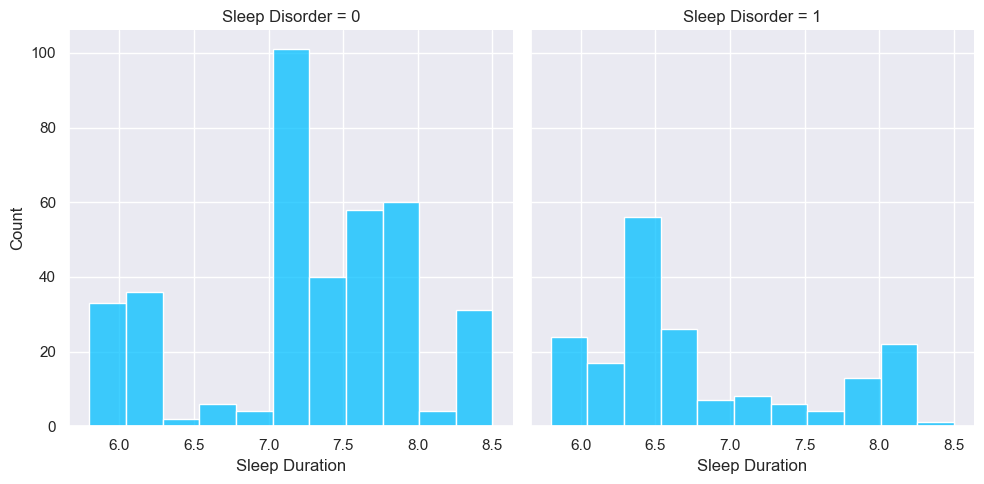

In [148]:
plt.figure(figsize=(10,6))
sns.displot(data=data_vis,col='Sleep Disorder',x='Sleep Duration',color='deepskyblue');

**Physical Activity Level**

<Figure size 1200x500 with 0 Axes>

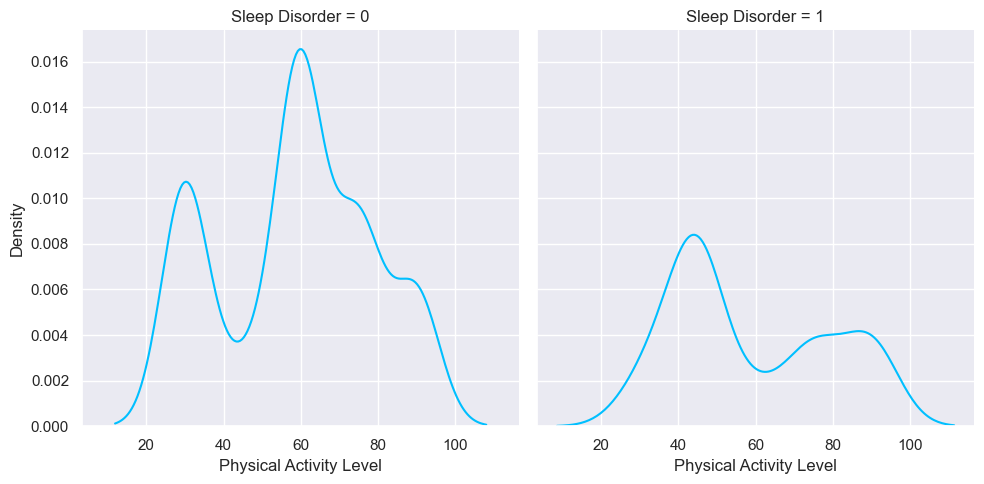

In [149]:
plt.figure(figsize=(12,5))
sns.displot(x='Physical Activity Level', col='Sleep Disorder' , data = data_vis, kind="kde" ,color = 'deepskyblue');

In [150]:
# Define the bins and labels based on min and max physical activity
bins = [30, 45, 60, 75, 90]  # Create bins within the range
labels = ['30-45', '45-60', '60-75', '75-90']  # Update labels to reflect the bins

# Categorize the 'Physical Activity' column into bins
physical_activity = pd.cut(data['Physical Activity Level'], bins=bins, labels=labels, right=False)

# Create the crosstab and convert it to float
activity_temp = pd.crosstab(data['Sleep Disorder'], physical_activity, rownames=['Sleep Disorder']).astype(float)
activity_temp

Physical Activity Level,30-45,45-60,60-75,75-90
Sleep Disorder,,,,
Insomnia,15.0,67.0,6.0,0.0
None,96.0,27.0,132.0,71.0
Sleep Apnea,14.0,5.0,8.0,34.0


<Figure size 1000x600 with 0 Axes>

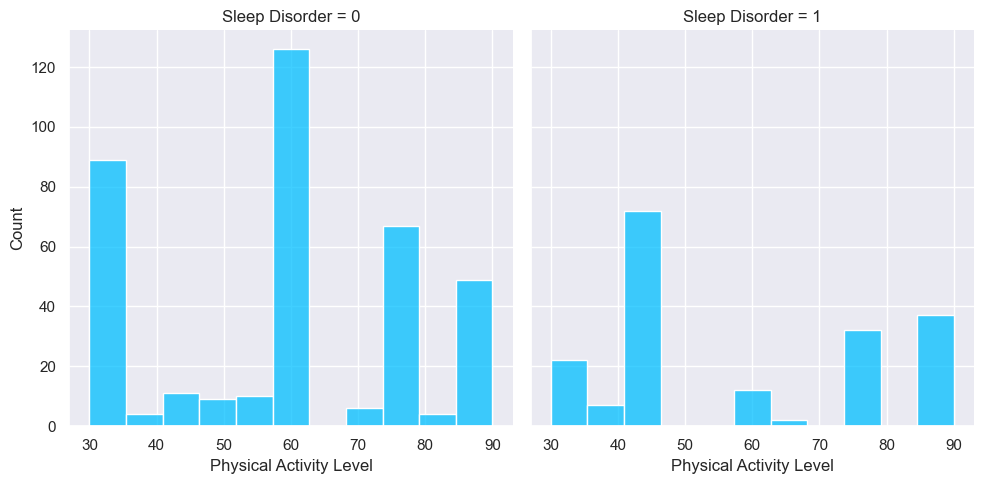

In [151]:
plt.figure(figsize=(10,6))
sns.displot(data=data_vis,col='Sleep Disorder',x='Physical Activity Level',color='deepskyblue');

**Bmi**

<Figure size 1200x500 with 0 Axes>

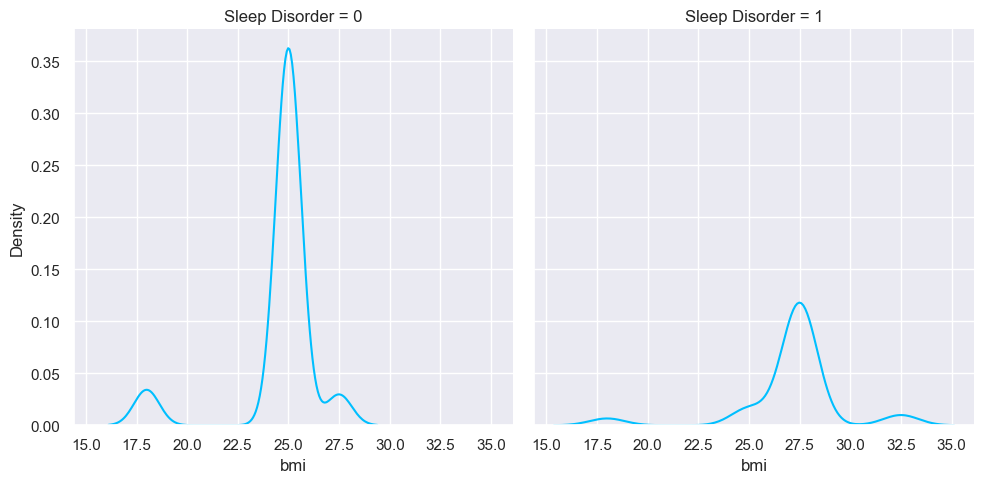

In [152]:
plt.figure(figsize=(12,5))
sns.displot(x='bmi', col='Sleep Disorder' , data = data_vis, kind="kde" ,color = 'deepskyblue');

In [153]:
# Define the bins and labels for BMI
bins = [18.0, 20.0, 25.0, 30.0, max(data['bmi']) + 0.5]  # Add a small buffer to include max BMI
labels = ['18-20', '20-25', '25-30', '30+']             # Labels reflecting common BMI categories

# Categorize the 'BMI' column into bins
bmi_category = pd.cut(data['bmi'], bins=bins, labels=labels, right=False)

# Create the crosstab and convert it to float
bmi_temp = pd.crosstab(data['Sleep Disorder'], bmi_category, rownames=['Sleep Disorder']).astype(float)
bmi_temp

bmi,18-20,25-30,30+
Sleep Disorder,,,
Insomnia,4.0,85.0,4.0
None,30.0,345.0,0.0
Sleep Apnea,4.0,79.0,8.0


<Figure size 1000x600 with 0 Axes>

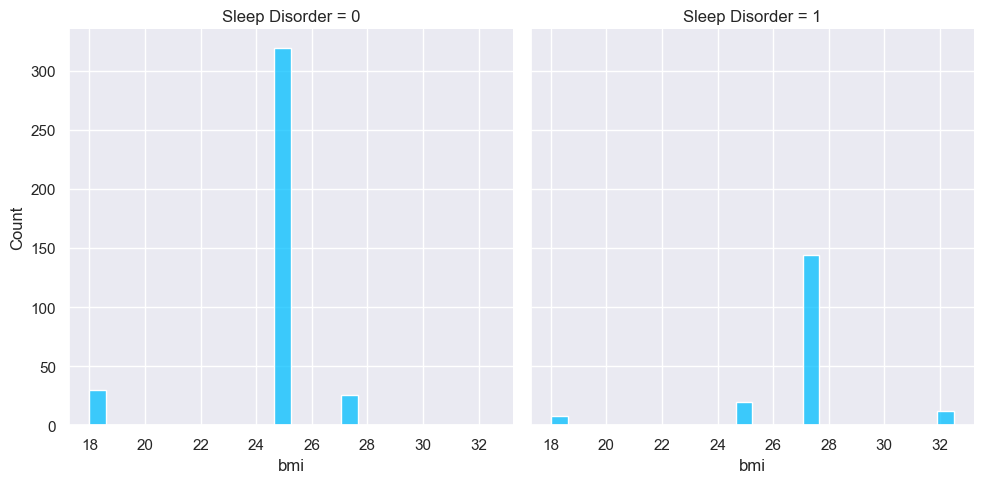

In [154]:
plt.figure(figsize=(10,6))
sns.displot(data=data_vis,col='Sleep Disorder',x='bmi',color='deepskyblue');

**Heart Rate**

<Figure size 1200x500 with 0 Axes>

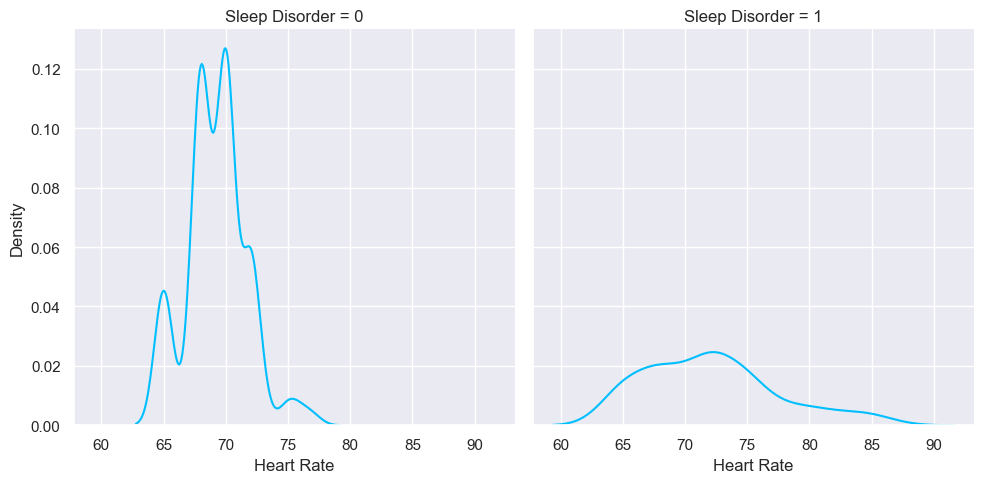

In [155]:
plt.figure(figsize=(12,5))
sns.displot(x='Heart Rate', col='Sleep Disorder' , data = data_vis, kind="kde" ,color = 'deepskyblue')

In [156]:
# Define the bins and labels for heart rate
bins = [65, 70, 75, 80, 86]  # Create bins within the heart rate range
labels = ['65-70', '70-75', '75-80', '80-86']  # Labels corresponding to the bins

# Categorize the 'Heart Rate' column into bins
heart_rate_category = pd.cut(data['Heart Rate'], bins=bins, labels=labels, right=False)

# Create the crosstab and convert it to float
heart_rate_temp = pd.crosstab(data['Sleep Disorder'], heart_rate_category, rownames=['Sleep Disorder']).astype(float)
heart_rate_temp


Heart Rate,65-70,70-75,75-80,80-86
Sleep Disorder,,,,
Insomnia,33.0,48.0,4.0,8.0
None,174.0,187.0,14.0,0.0
Sleep Apnea,32.0,10.0,35.0,12.0


<Figure size 1000x600 with 0 Axes>

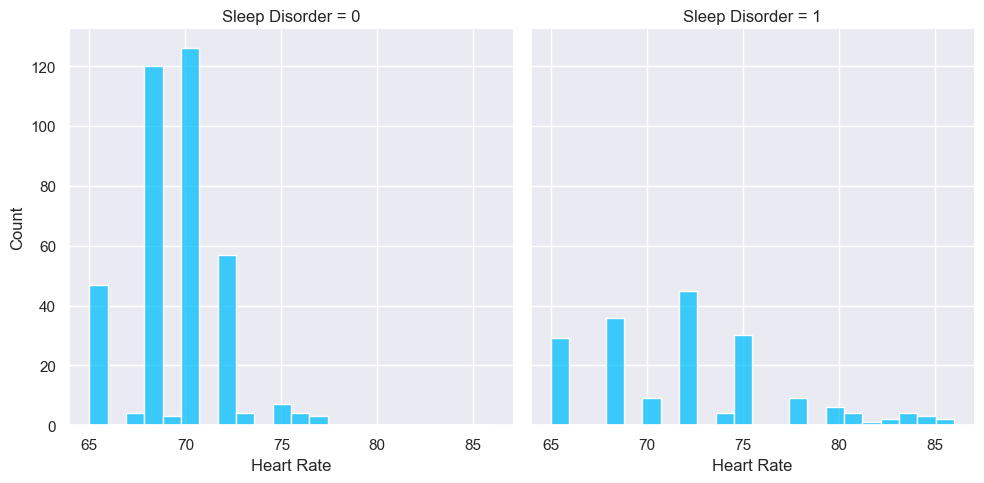

In [157]:
plt.figure(figsize=(10,6))
sns.displot(data=data_vis,col='Sleep Disorder',x='Heart Rate',color='deepskyblue');

**Daily Steps**

<Figure size 1200x500 with 0 Axes>

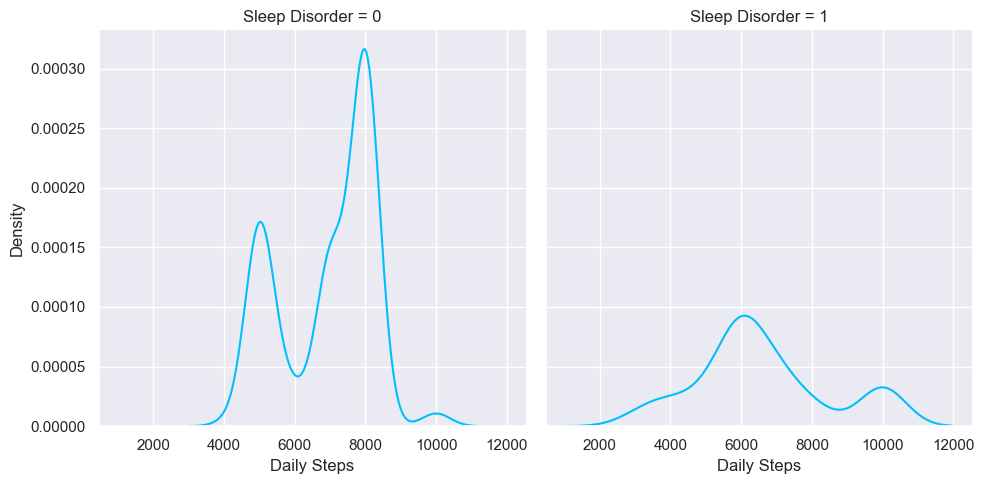

In [158]:
plt.figure(figsize=(12,5))
sns.displot(x='Daily Steps', col='Sleep Disorder' , data = data_vis, kind="kde" ,color = 'deepskyblue');

In [159]:
# Define the bins and labels for daily steps
bins = [3000, 5000, 7000, 9000, 10000]  # Create bins within the range
labels = ['3000-5000', '5000-7000', '7000-9000', '9000-10000']  # Labels for the bins

# Categorize the 'Daily Steps' column into bins
daily_steps_category = pd.cut(data['Daily Steps'], bins=bins, labels=labels, right=False)

# Create the crosstab and convert it to float
daily_steps_temp = pd.crosstab(data['Sleep Disorder'], daily_steps_category, rownames=['Sleep Disorder']).astype(float)
daily_steps_temp

Daily Steps,3000-5000,5000-7000,7000-9000
Sleep Disorder,,,
Insomnia,12.0,72.0,8.0
None,3.0,117.0,249.0
Sleep Apnea,14.0,11.0,37.0


<Figure size 1000x600 with 0 Axes>

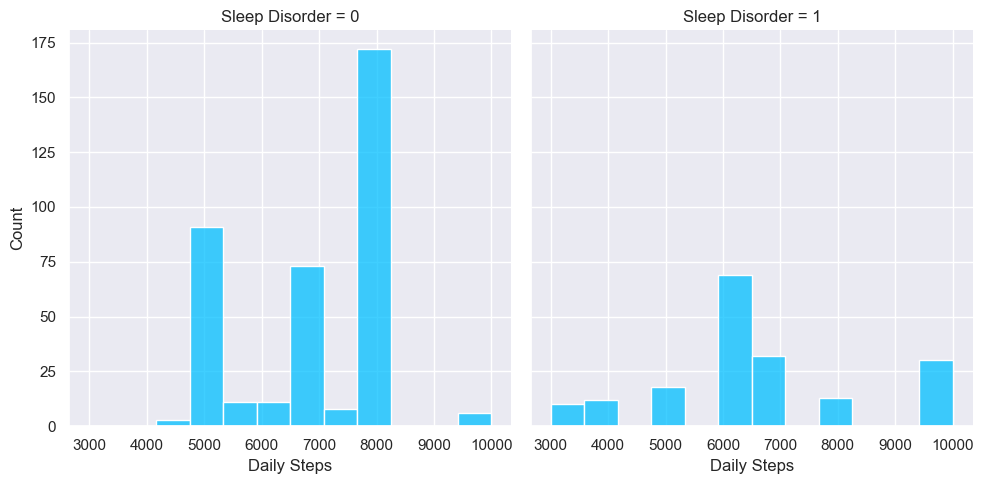

In [160]:
plt.figure(figsize=(10,6))
sns.displot(data=data_vis,col='Sleep Disorder',x='Daily Steps',color='deepskyblue');

**Quality of Sleep**

<Figure size 1200x500 with 0 Axes>

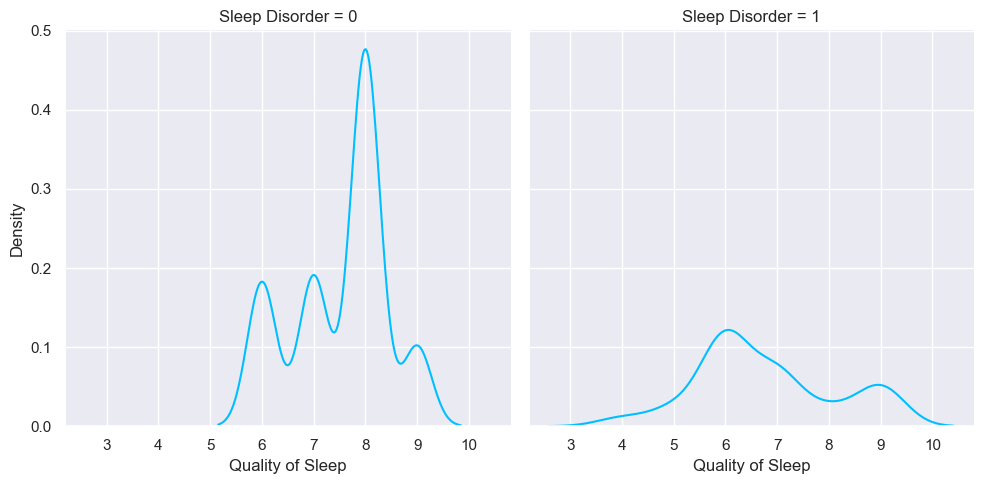

In [161]:
plt.figure(figsize=(12,5))
sns.displot(x='Quality of Sleep', col='Sleep Disorder' , data = data_vis, kind="kde" ,color = 'deepskyblue');

In [162]:
# Define the bins and labels for Quality of Sleep
bins = [4, 5, 6, 7, 8, 9]  # Create bins within the range
labels = ['4-5', '5-6', '6-7', '7-8', '8-9']  # Labels for the bins

# Categorize the 'Quality of Sleep' column into bins
sleep_quality_category = pd.cut(data['Quality of Sleep'], bins=bins, labels=labels, right=False)

# Create the crosstab and convert it to float
sleep_quality_temp = pd.crosstab(data['Sleep Disorder'], sleep_quality_category, rownames=['Sleep Disorder']).astype(float)
sleep_quality_temp

Quality of Sleep,4-5,5-6,6-7,7-8,8-9
Sleep Disorder,,,,,
Insomnia,1.0,8.0,38.0,37.0,8.0
None,0.0,0.0,72.0,75.0,188.0
Sleep Apnea,6.0,6.0,36.0,6.0,5.0


<Figure size 1000x600 with 0 Axes>

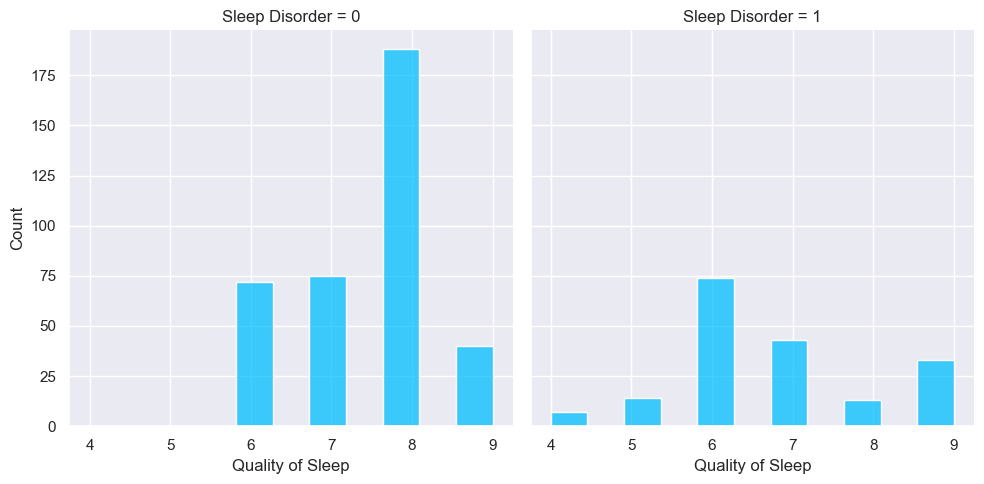

In [163]:
plt.figure(figsize=(10,6))
sns.displot(data=data_vis,col='Sleep Disorder',x='Quality of Sleep',color='deepskyblue');

**Stress Level**

<Figure size 1200x500 with 0 Axes>

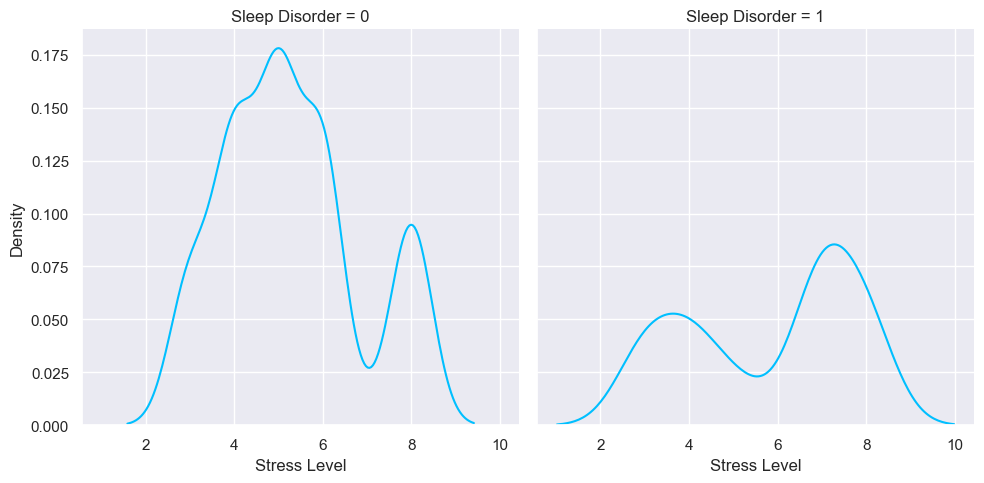

In [164]:
plt.figure(figsize=(12,5))
sns.displot(x='Stress Level', col='Sleep Disorder' , data = data_vis, kind="kde" ,color = 'deepskyblue');

In [165]:
# Define the bins and labels for Stress Level
bins = [3, 4, 5, 6, 7, 8]  # Create bins within the range
labels = ['3-4', '4-5', '5-6', '6-7', '7-8']  # Labels for the bins

# Categorize the 'Stress Level' column into bins
stress_level_category = pd.cut(data['Stress Level'], bins=bins, labels=labels, right=False)

# Create the crosstab and convert it to float
stress_level_temp = pd.crosstab(data['Sleep Disorder'], stress_level_category, rownames=['Sleep Disorder']).astype(float)
stress_level_temp

Stress Level,3-4,4-5,5-6,6-7,7-8
Sleep Disorder,,,,,
Insomnia,1.0,28.0,8.0,2.0,50.0
None,44.0,83.0,100.0,83.0,3.0
Sleep Apnea,30.0,4.0,7.0,2.0,11.0


<Figure size 1000x600 with 0 Axes>

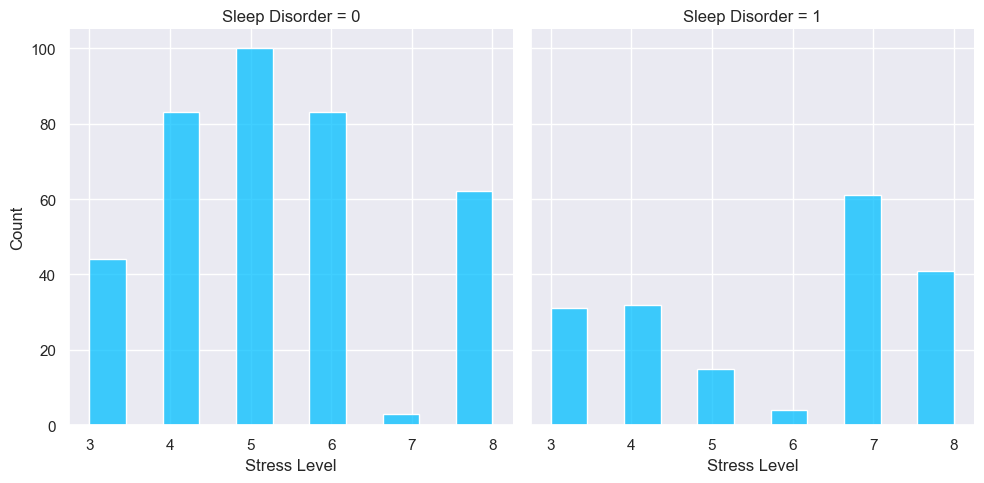

In [166]:
plt.figure(figsize=(10,6))
sns.displot(data=data_vis,col='Sleep Disorder',x='Stress Level',color='deepskyblue');

**Systolic_Bp**

<Figure size 1200x500 with 0 Axes>

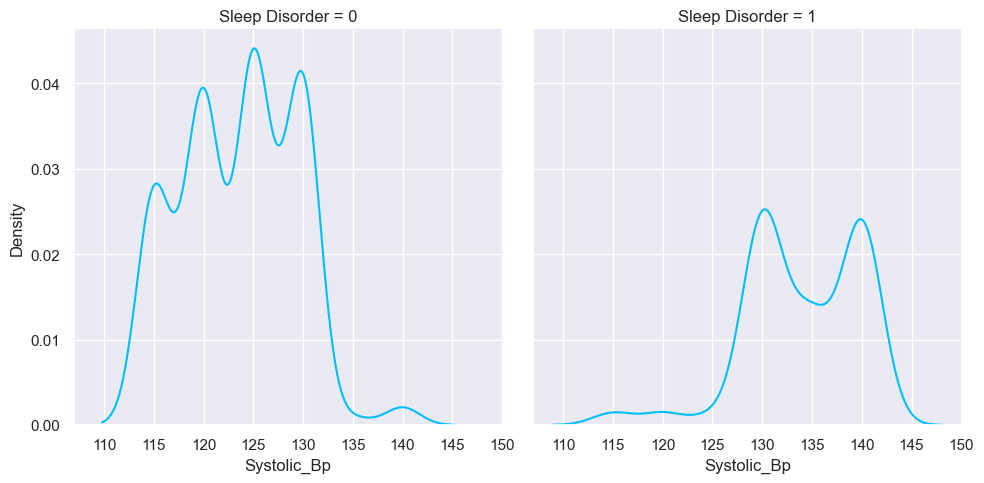

In [167]:
plt.figure(figsize=(12,5))
sns.displot(x='Systolic_Bp', col='Sleep Disorder' , data = data_vis, kind="kde" ,color = 'deepskyblue');

In [168]:
# Define the bins and labels for Systolic Blood Pressure
bins = [115, 120, 130, 140, 142]  # Create bins within the range
labels = ['115-120', '120-130', '130-140', '140-142']  # Labels for the bins

# Categorize the 'Systolic_Bp' column into bins
systolic_bp_category = pd.cut(data['Systolic_Bp'], bins=bins, labels=labels, right=False)

# Create the crosstab and convert it to float
systolic_bp_temp = pd.crosstab(data['Sleep Disorder'], systolic_bp_category, rownames=['Sleep Disorder']).astype(float)
systolic_bp_temp

Systolic_Bp,115-120,120-130,130-140,140-142
Sleep Disorder,,,,
Insomnia,2.0,5.0,81.0,3.0
None,75.0,200.0,95.0,5.0
Sleep Apnea,2.0,6.0,22.0,61.0


<Figure size 1000x600 with 0 Axes>

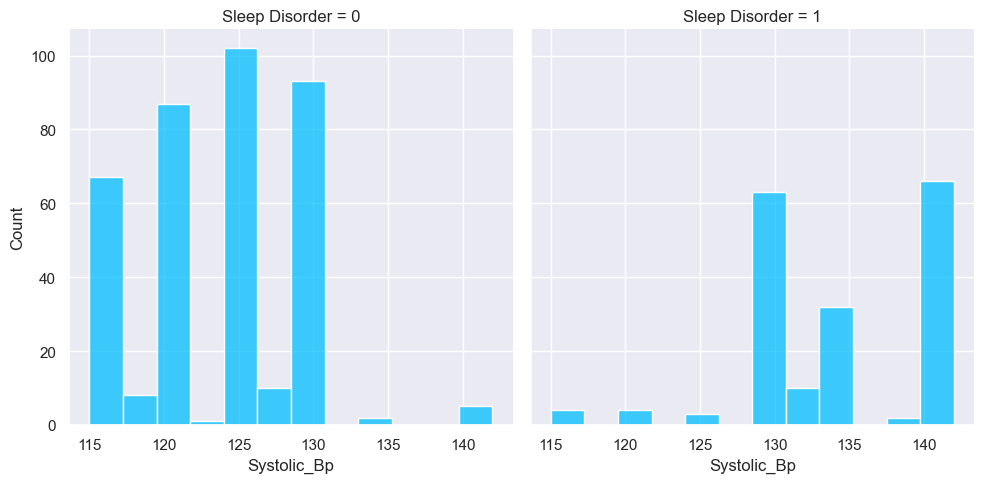

In [169]:
plt.figure(figsize=(10,6))
sns.displot(data=data_vis,col='Sleep Disorder',x='Systolic_Bp',color='deepskyblue');

**Dystolic_Bp**

<Figure size 1200x500 with 0 Axes>

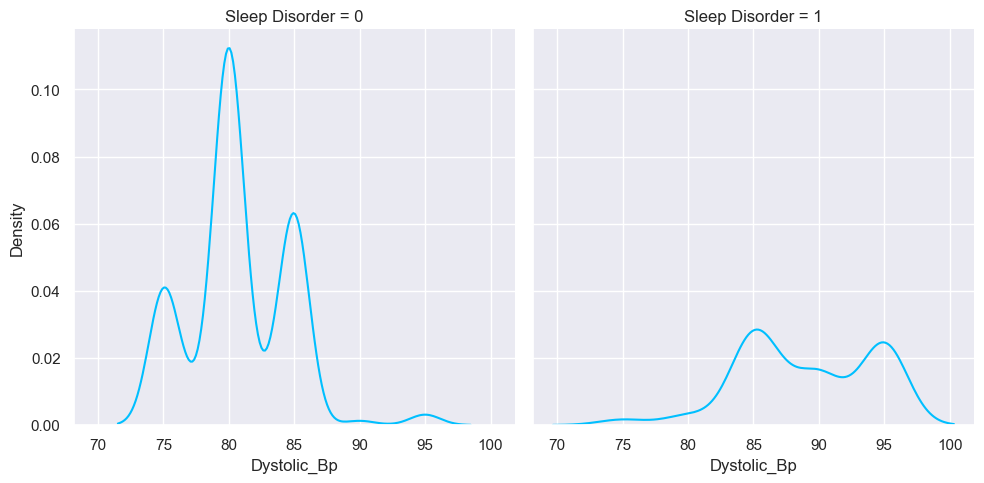

In [170]:
plt.figure(figsize=(12,5))
sns.displot(x='Dystolic_Bp', col='Sleep Disorder' , data = data_vis, kind="kde" ,color = 'deepskyblue');

In [171]:
# Define the bins and labels for Diastolic Blood Pressure
bins = [75, 80, 85, 90, 95]  # Create bins within the range
labels = ['75-80', '80-85', '85-90', '90-95']  # Labels for the bins

# Categorize the 'Dystolic_Bp' column into bins
dystolic_bp_category = pd.cut(data['Dystolic_Bp'], bins=bins, labels=labels, right=False)

# Create the crosstab and convert it to float
dystolic_bp_temp = pd.crosstab(data['Sleep Disorder'], dystolic_bp_category, rownames=['Sleep Disorder']).astype(float)
dystolic_bp_temp

Dystolic_Bp,75-80,80-85,85-90,90-95
Sleep Disorder,,,,
Insomnia,2.0,5.0,53.0,32.0
None,77.0,192.0,99.0,2.0
Sleep Apnea,2.0,6.0,20.0,4.0


<Figure size 1000x600 with 0 Axes>

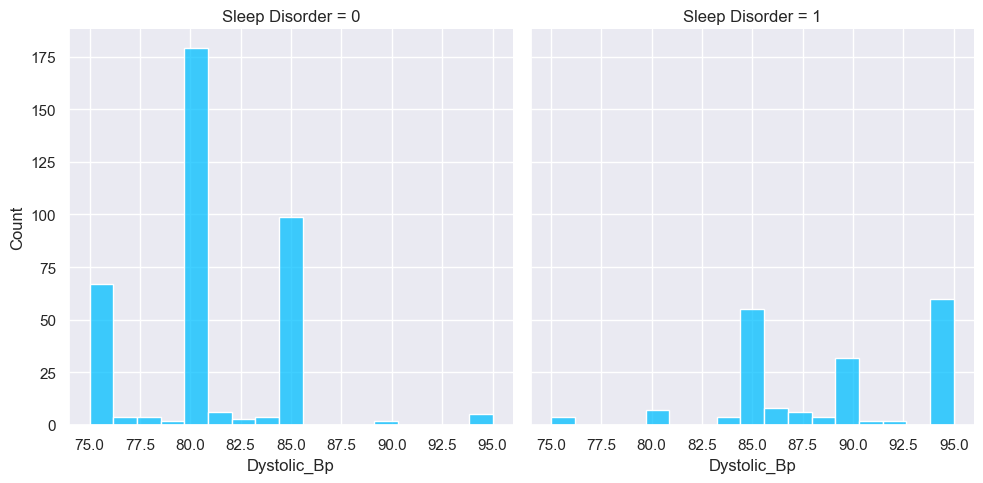

In [172]:
plt.figure(figsize=(10,6))
sns.displot(data=data_vis,col='Sleep Disorder',x='Dystolic_Bp',color='deepskyblue');

###**2.8 Distribution of numeric Features by sleep disorder and medical features**

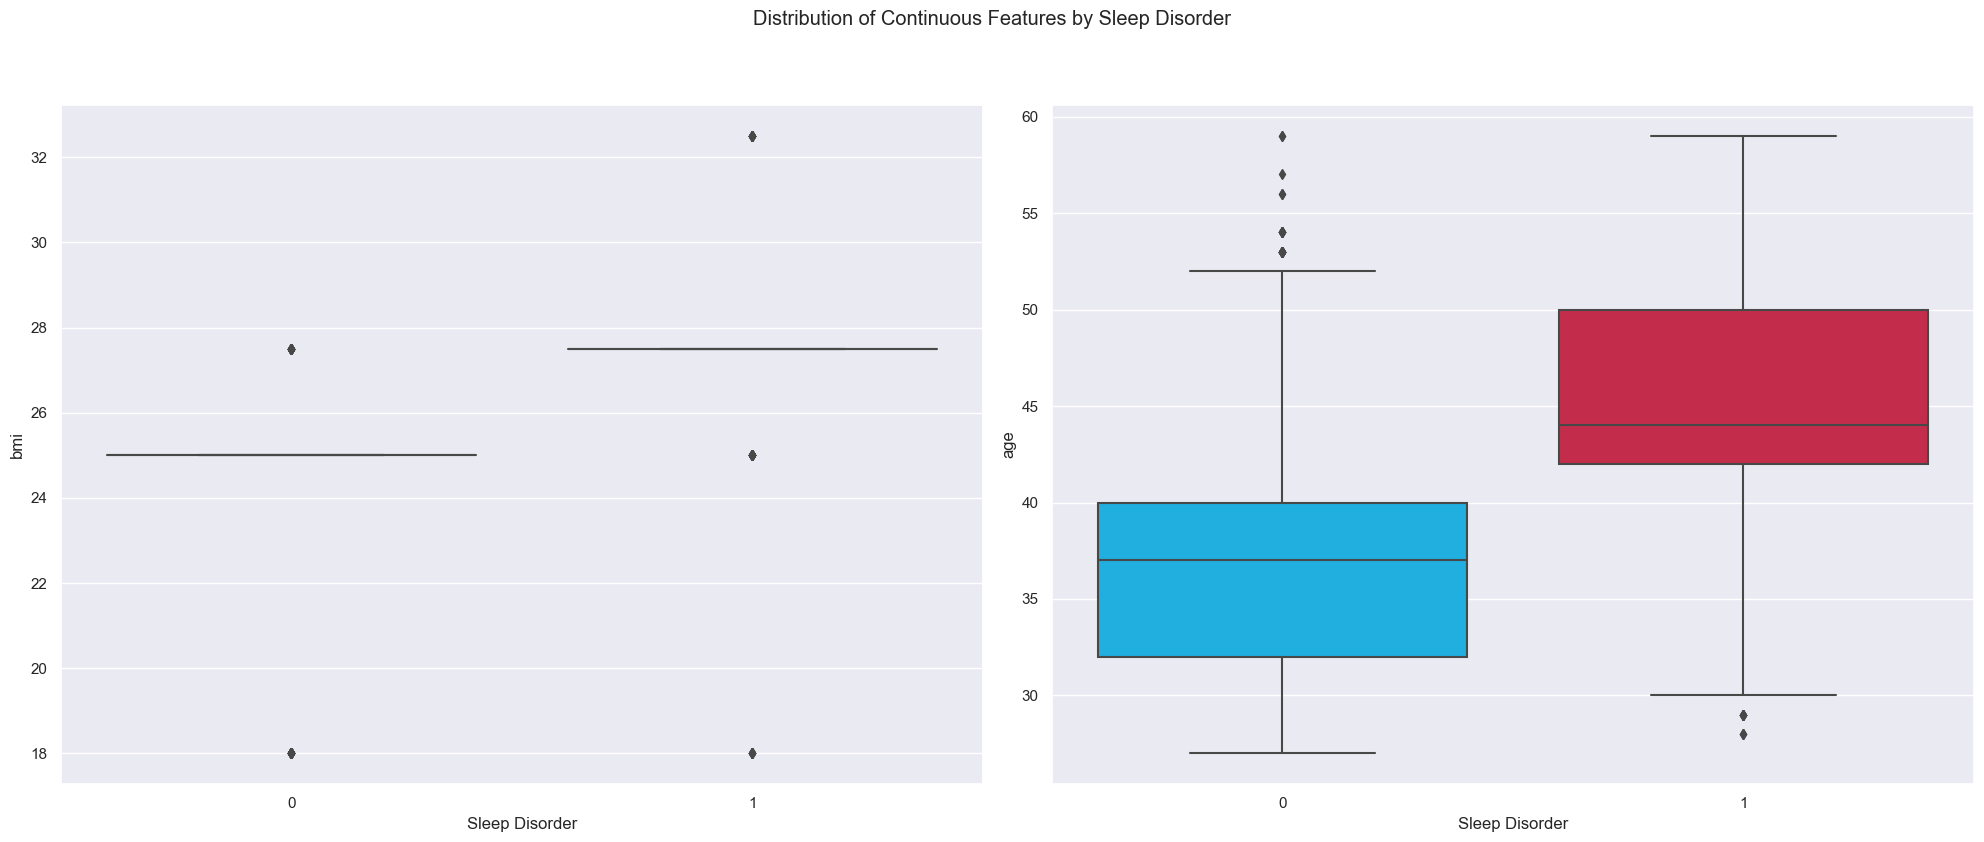

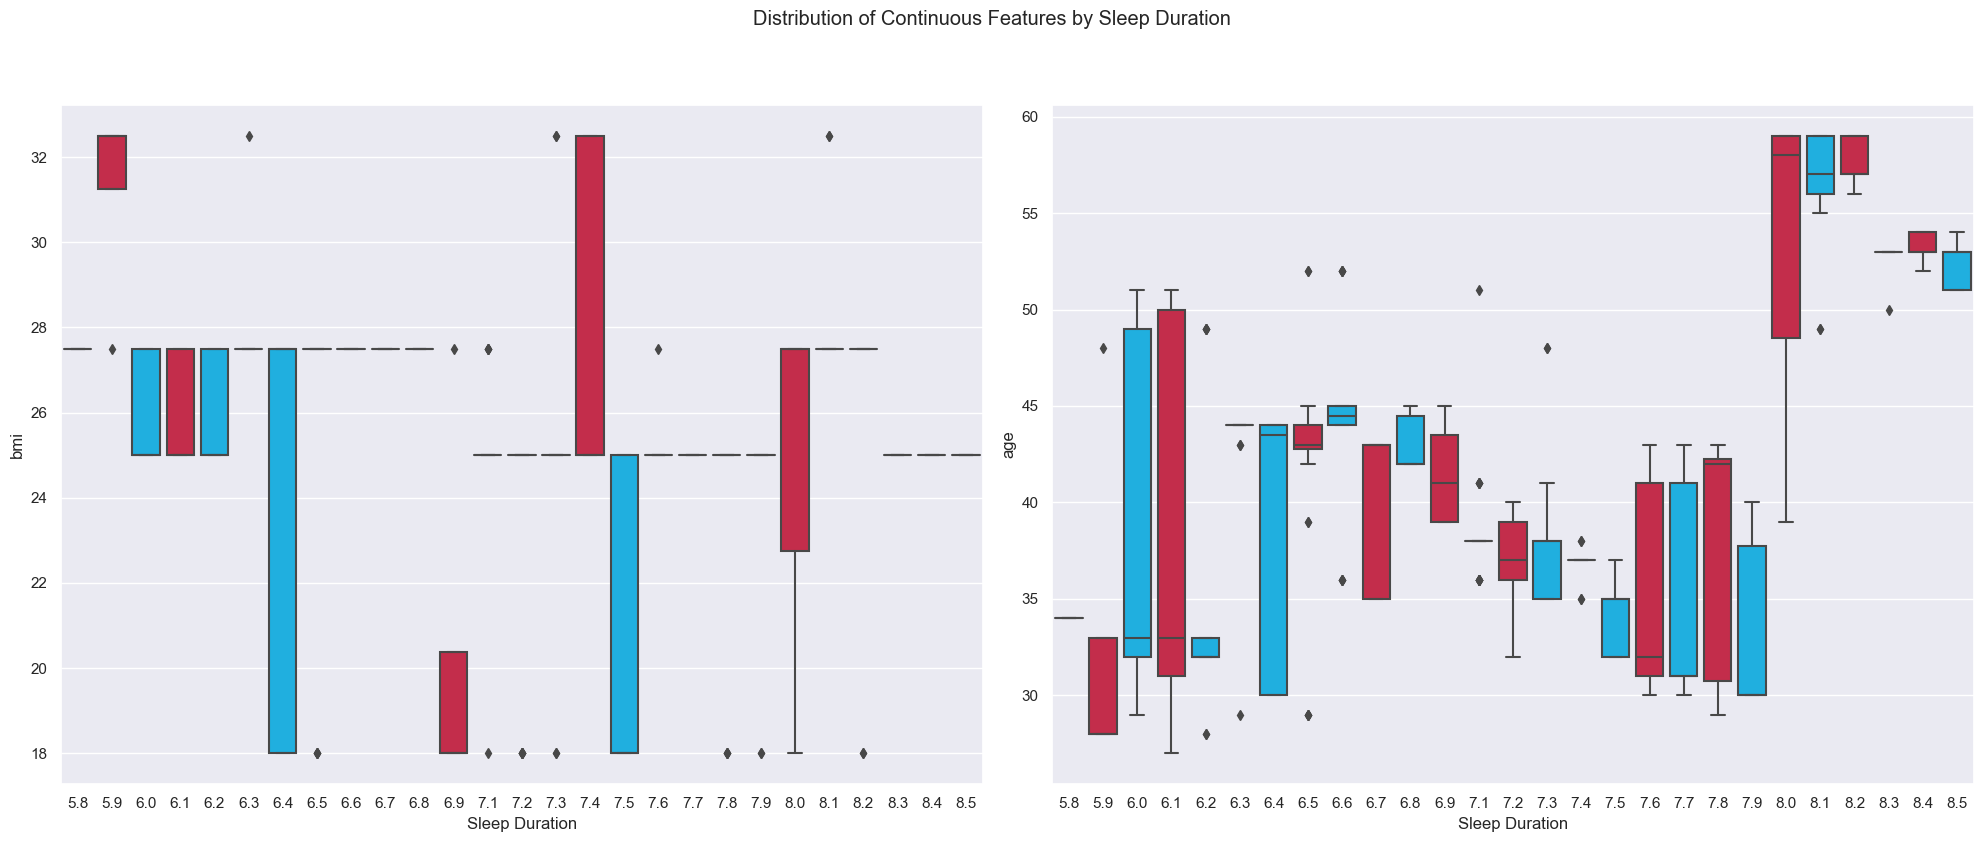

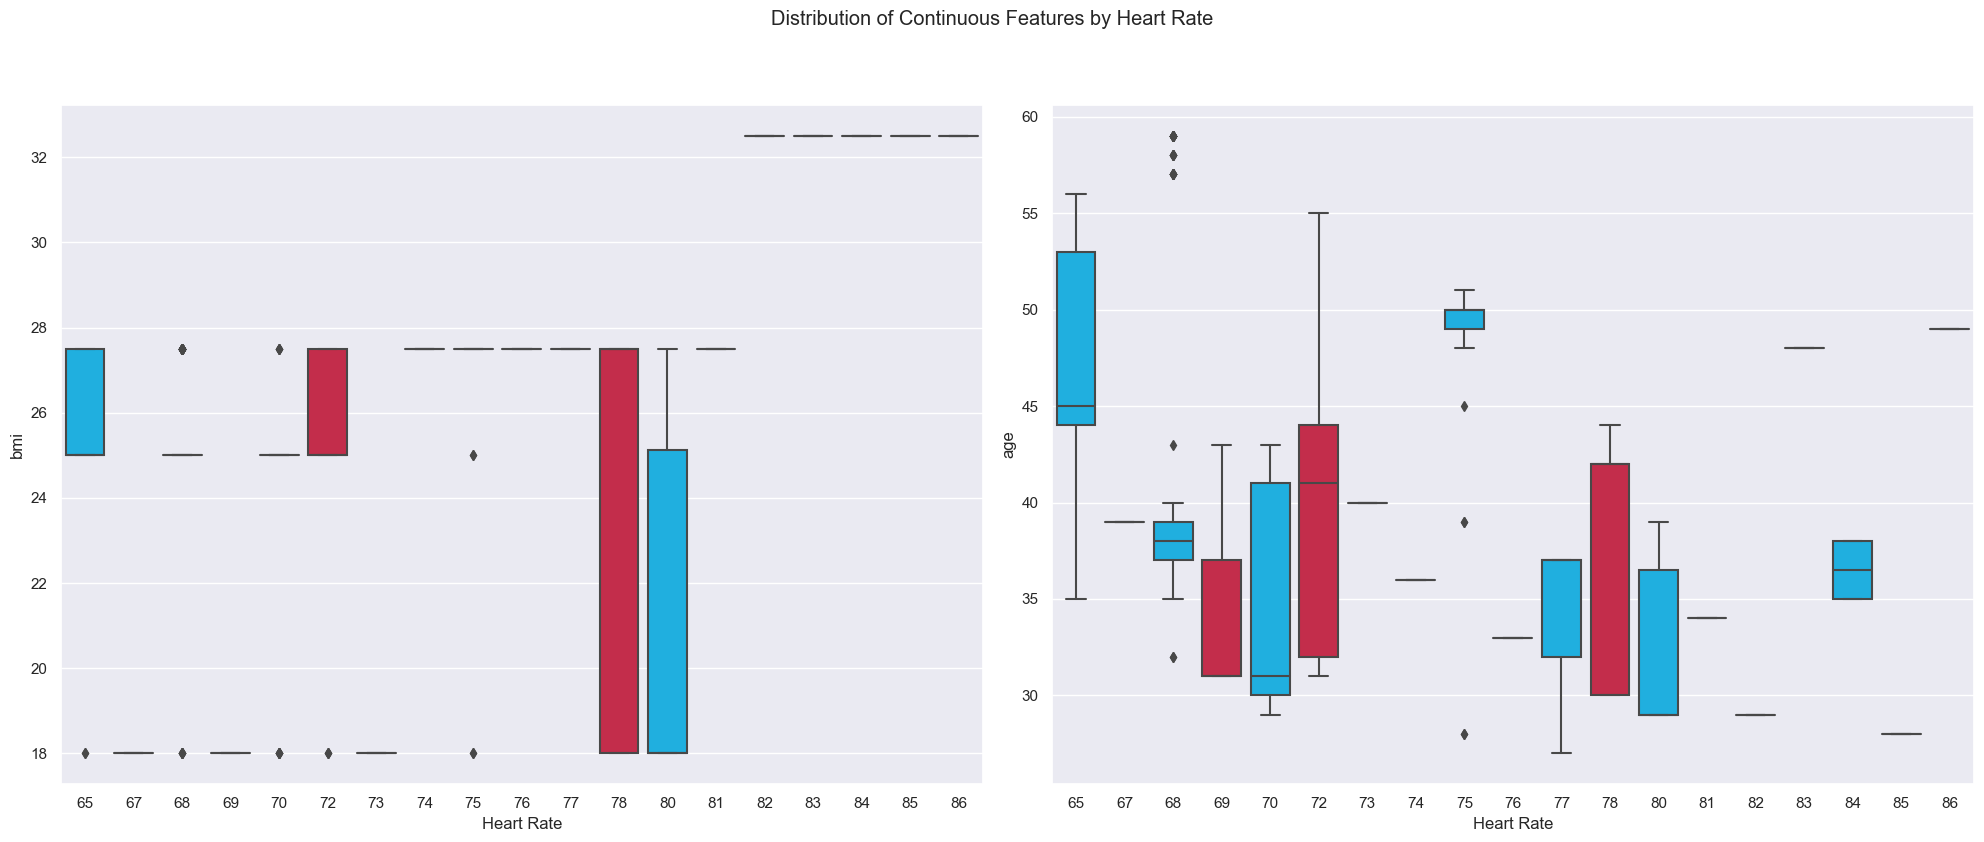

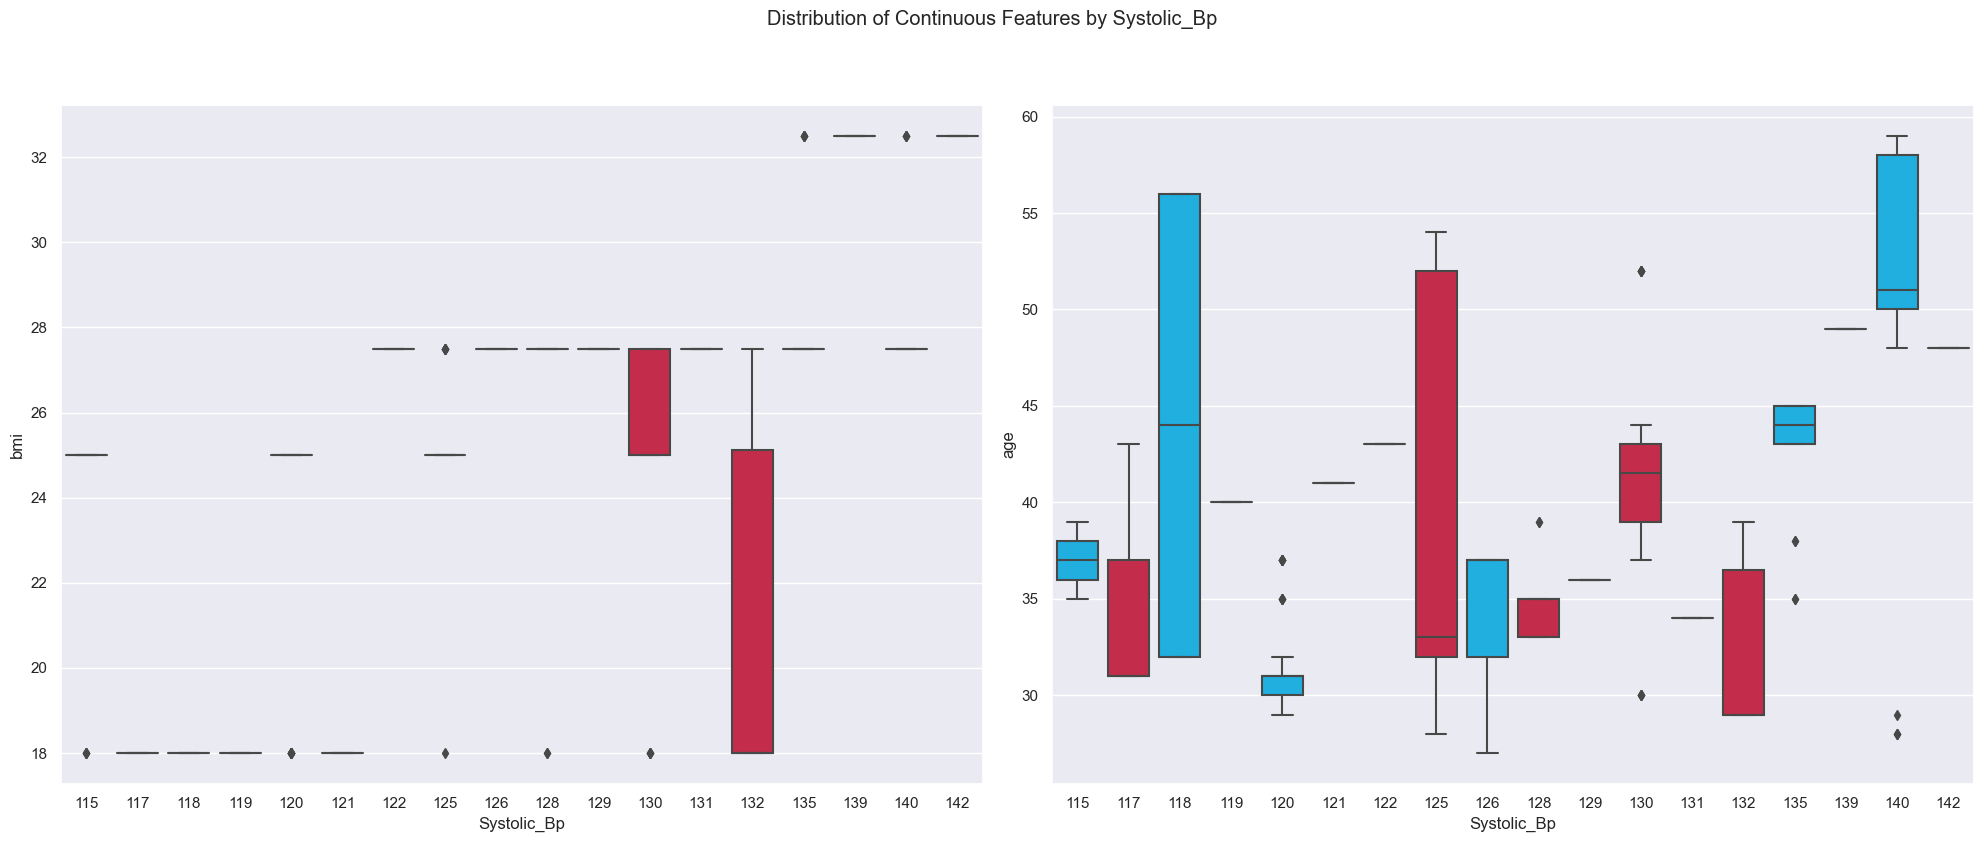

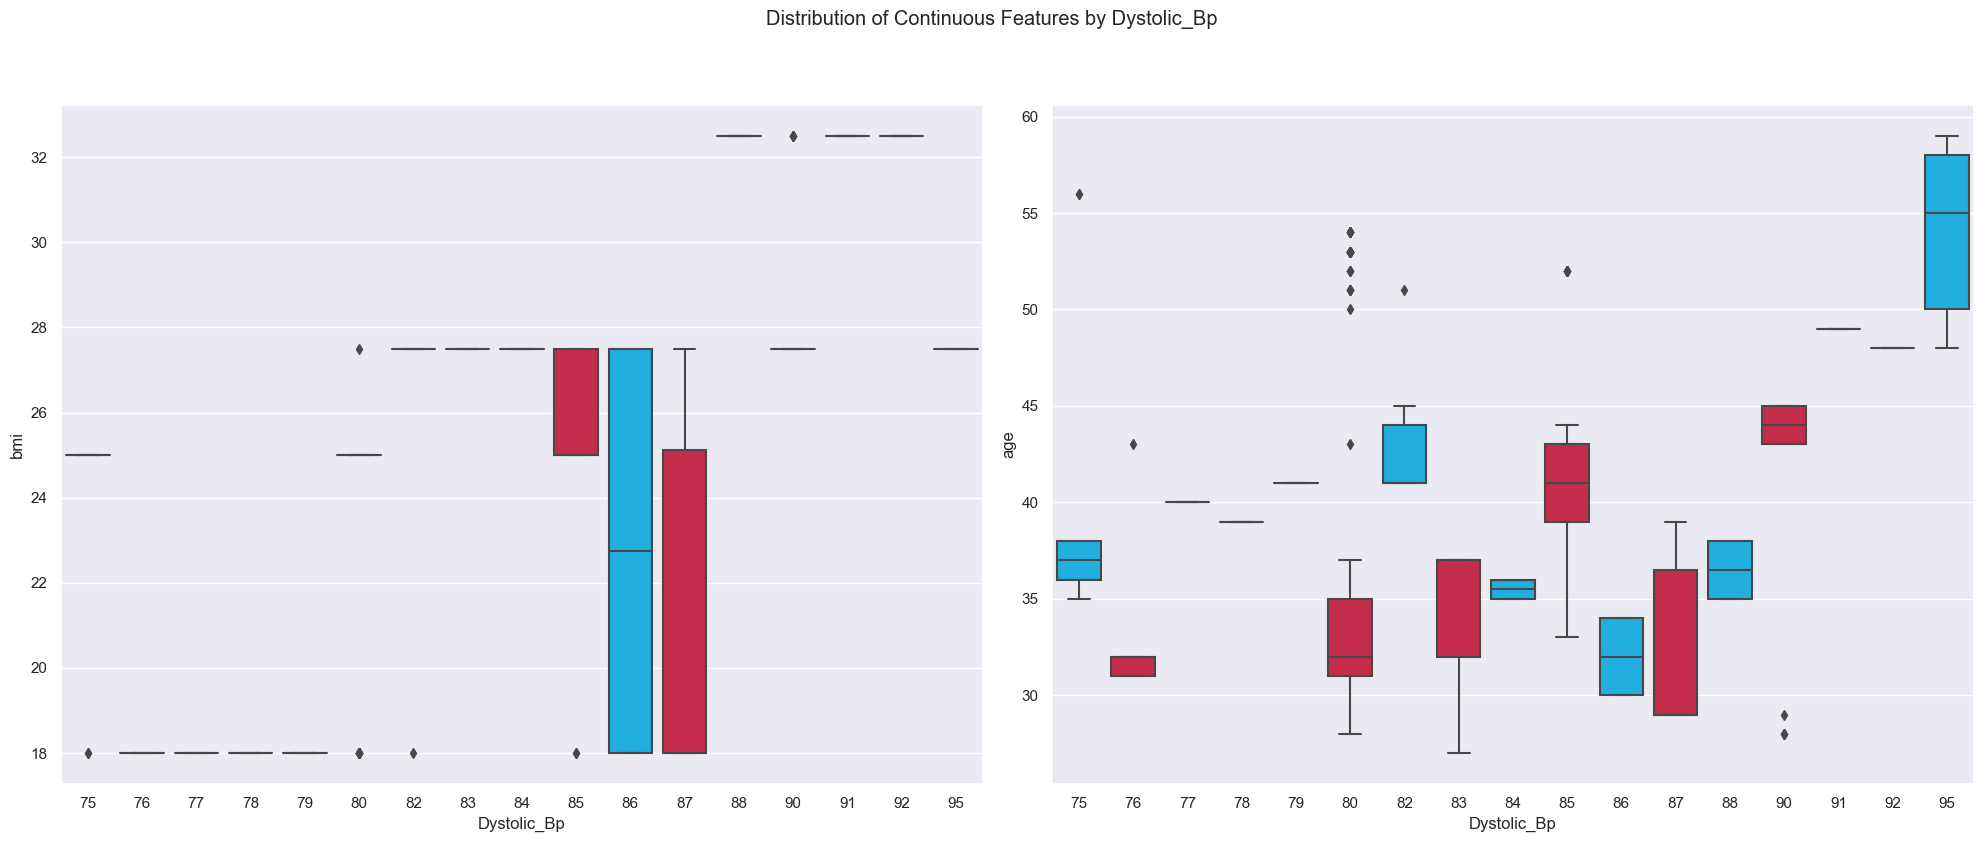

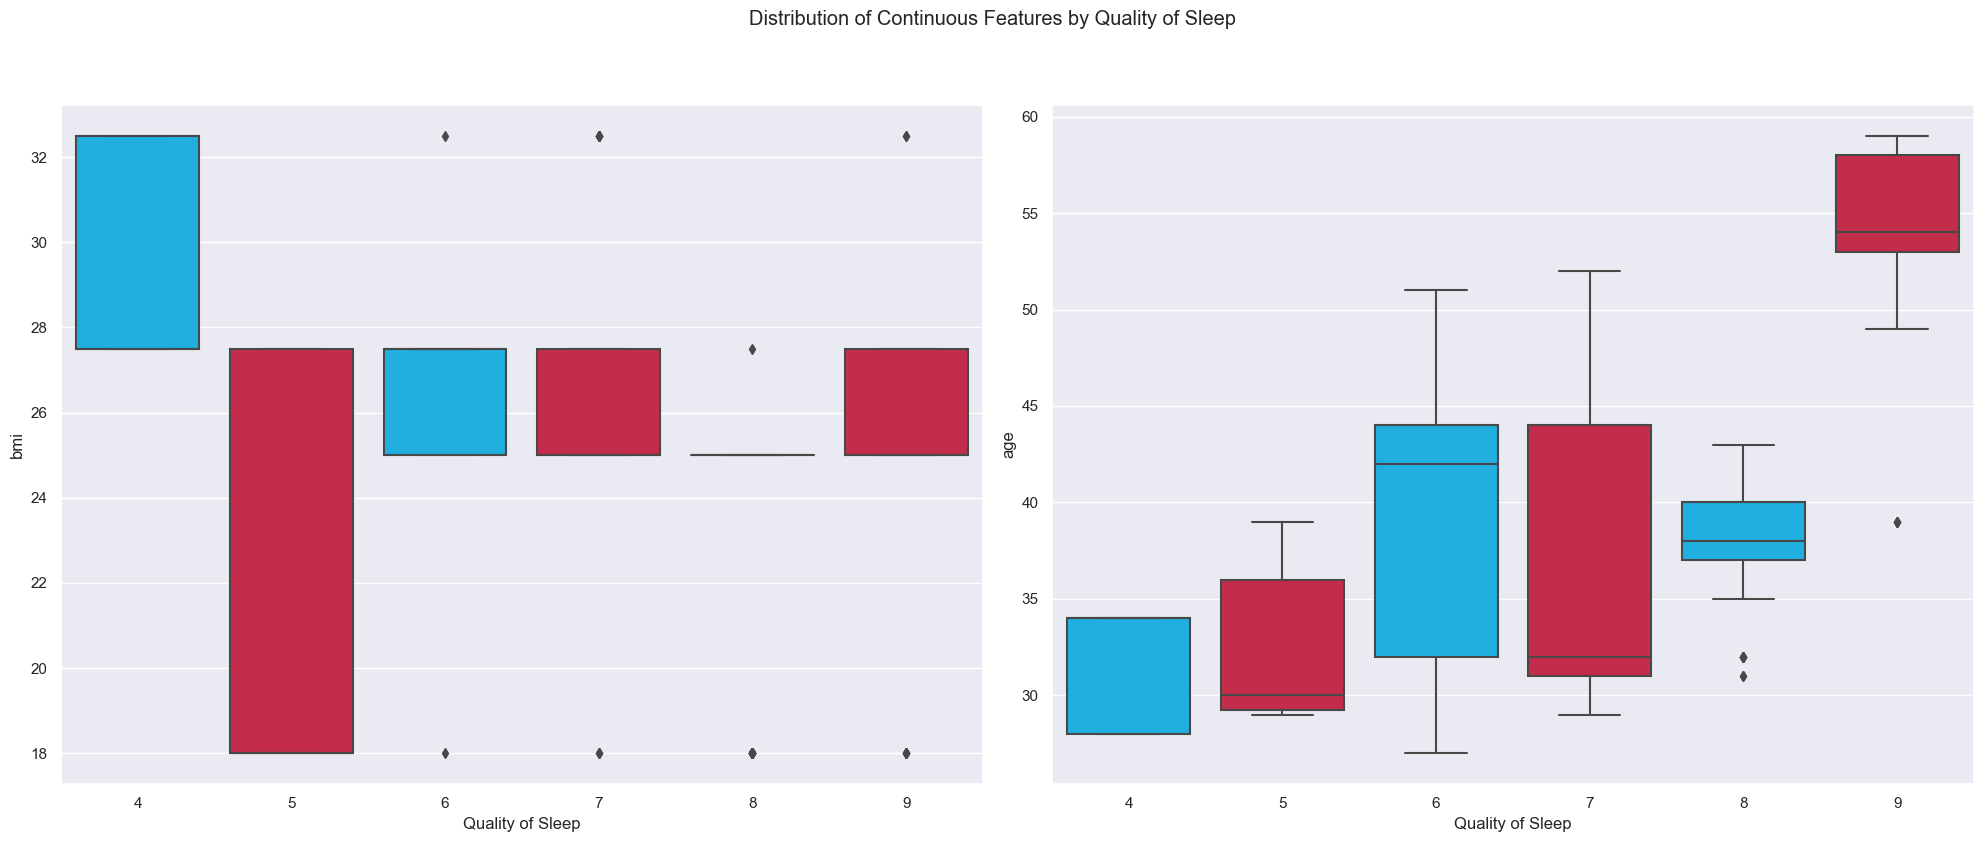

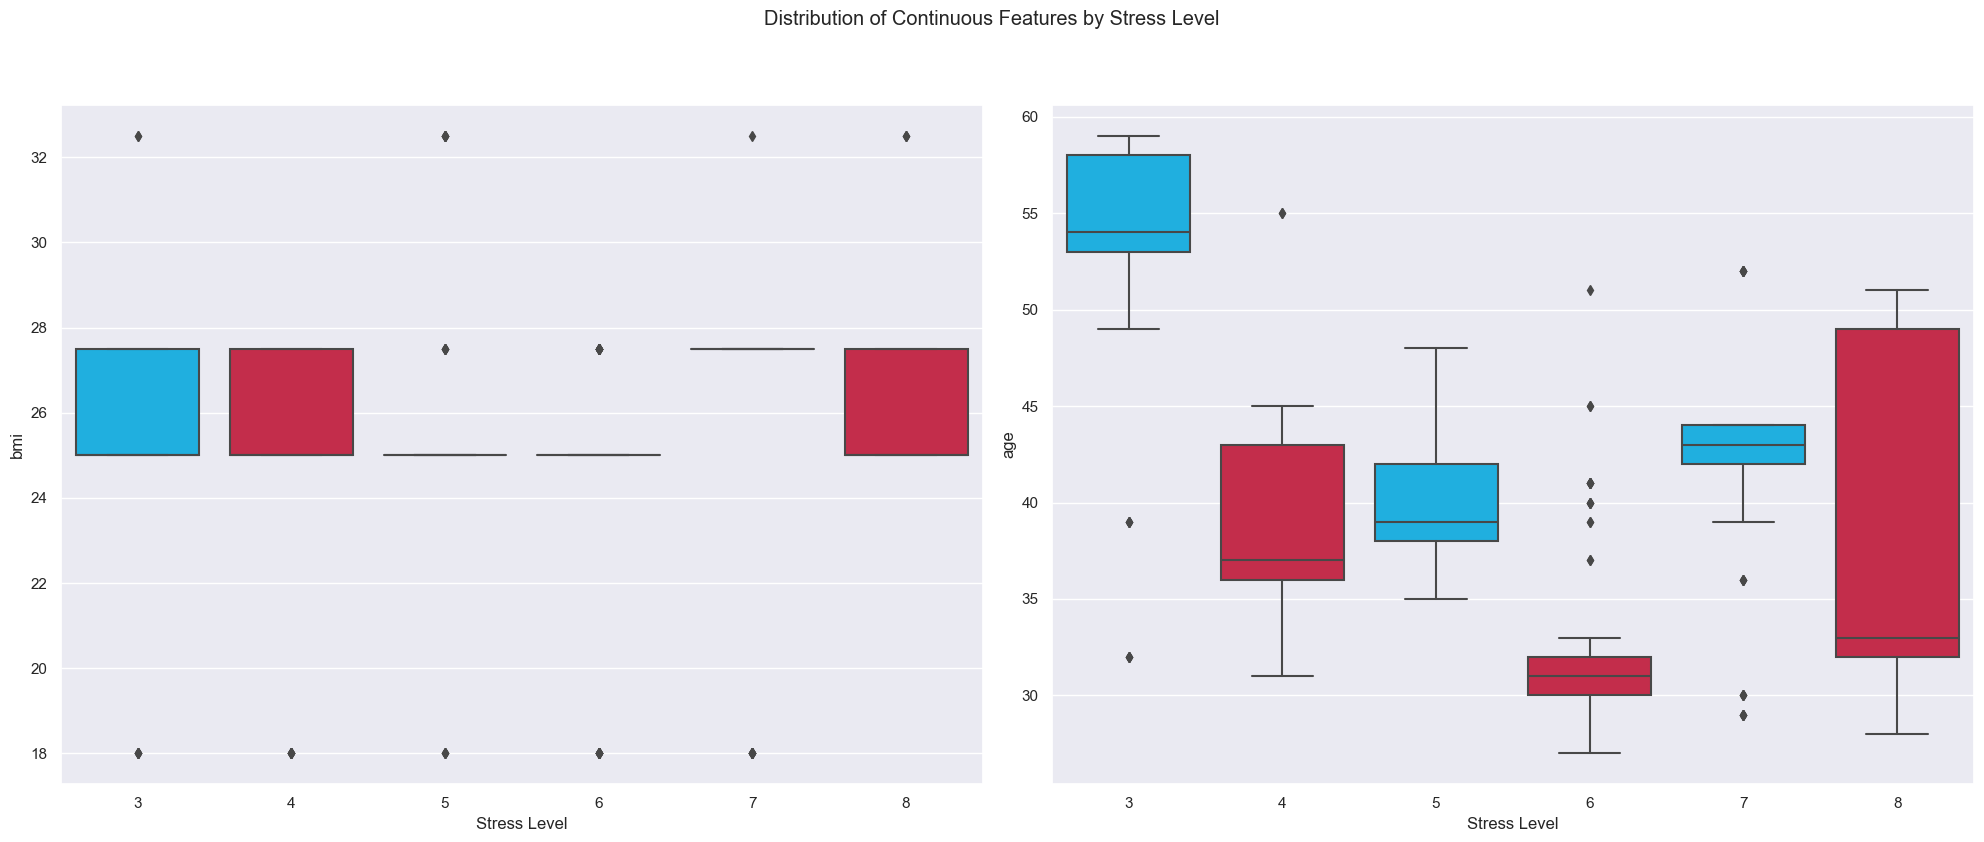

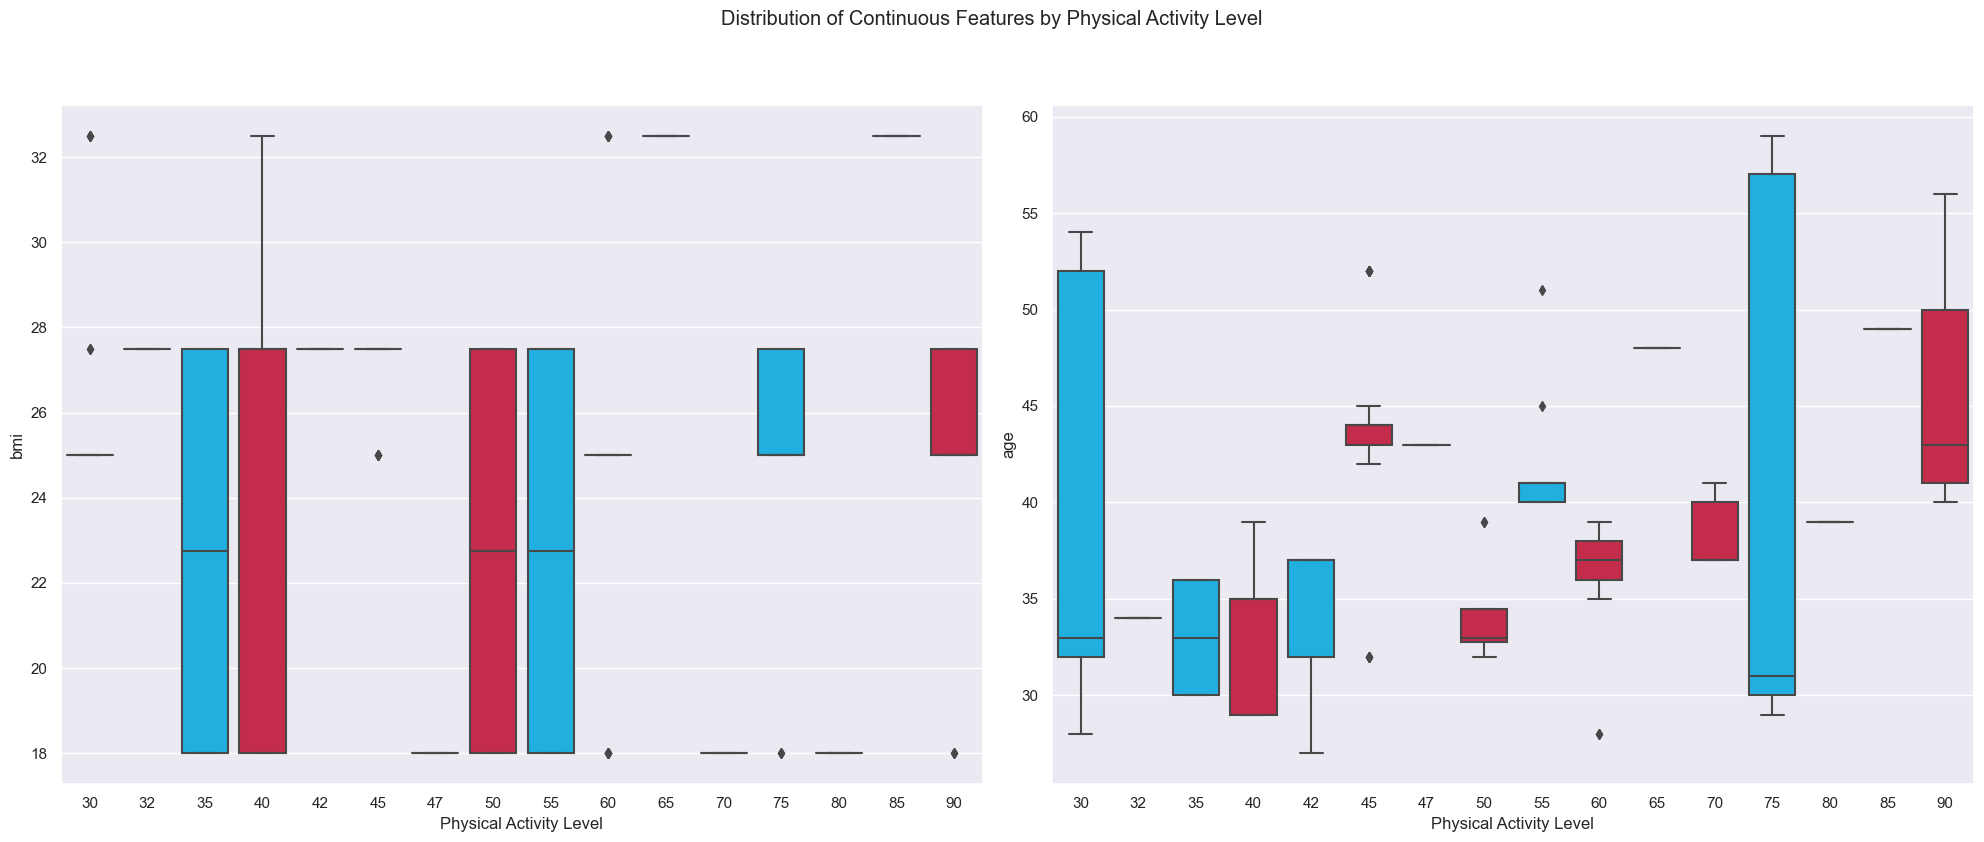

In [173]:
features = ['Sleep Disorder','Sleep Duration','Heart Rate','Systolic_Bp','Dystolic_Bp','Quality of Sleep','Stress Level','Physical Activity Level']
for i in enumerate(features):
  box_cols = ['bmi', 'age']
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
  fig.suptitle('Distribution of Continuous Features by '+i[1], y = 1.05);
  for col, ax in zip(box_cols, axes.ravel()):
      sns.boxplot(data=data_vis, x=i[1], y=col ,palette = ['deepskyblue','crimson'], ax=ax)
  plt.tight_layout()

#**3. Data Preparation**

###**3.1 Skewness Checking**

In [174]:
# Select only numeric columns from the dataset
numeric_columns = data.select_dtypes(include=['number']).columns

# Calculate skewness for all numeric columns
data_skew = data[numeric_columns]
skew = pd.DataFrame(data_skew.skew())

# Rename the column for clarity
skew.columns = ['skew']

# Add a column to identify if the skewness is considered "too skewed" (greater than 0.75)
skew['too_skewed'] = skew['skew'].abs() > 0.75  # Using absolute skewness value to check for both negative and positive skew

# Display the skewness results
skew

,skew,too_skewed
sex,0.293683,False
age,0.657817,False
Sleep Duration,-0.057731,False
Physical Activity Level,0.051568,False
bmi,-1.153584,True
Heart Rate,1.346890,True
Daily Steps,-0.023126,False
Person ID,0.000000,False
Quality of Sleep,-0.318620,False
Stress Level,0.166216,False


There are 2 columns with high Skewness.
Therefore, we will normalize them using the QuantileTransformer method.

In [175]:
qt = QuantileTransformer(n_quantiles=500, output_distribution='normal')
data[['bmi']] = qt.fit_transform(data[['bmi']])
data[['Heart Rate']] = qt.fit_transform(data[['Heart Rate']])

In [176]:
data_skew = data[['bmi','Heart Rate']]
skew = pd.DataFrame(data_skew.skew())
skew.columns = ['skew']
skew['too_skewed'] = skew['skew'] > .75
skew

,skew,too_skewed
bmi,-1.117694,False
Heart Rate,-1.448391,False


Now, the columns are not skewed.

###**3.2 Data Scaling**

In [177]:
sc = StandardScaler()
data[['bmi']] = sc.fit_transform(data[['bmi']])
data[['age']] = sc.fit_transform(data[['Heart Rate']])
data.head()

,sex,age,Sleep Duration,Physical Activity Level,bmi,Heart Rate,Daily Steps,Sleep Disorder,Person ID,Occupation,Quality of Sleep,Stress Level,Systolic_Bp,Dystolic_Bp
0,0,1.015786,6.1,42,0.665221,1.579469,4200,None,1,Software Engineer,6,6,126,83
1,0,0.868103,6.2,60,-0.106108,1.280411,10000,None,2,Doctor,6,8,125,80
2,0,0.868103,6.2,60,-0.106108,1.280411,10000,None,3,Doctor,6,8,125,80
3,0,1.507471,5.9,30,3.239318,2.575137,3000,Sleep Apnea,4,Sales Representative,4,8,140,90
4,0,1.507471,5.9,30,3.239318,2.575137,3000,Sleep Apnea,5,Sales Representative,4,8,140,90


###**3.3 Data Splitting**

In [178]:
data.drop(['Person ID','Occupation','Quality of Sleep','Stress Level','Physical Activity Level','bmi'],axis = 1, inplace = True)
data.rename(columns={'Heart Rate': 'Bpm'}, inplace=True)
data.head()

,sex,age,Sleep Duration,Bpm,Daily Steps,Sleep Disorder,Systolic_Bp,Dystolic_Bp
0,0,1.015786,6.1,1.579469,4200,None,126,83
1,0,0.868103,6.2,1.280411,10000,None,125,80
2,0,0.868103,6.2,1.280411,10000,None,125,80
3,0,1.507471,5.9,2.575137,3000,Sleep Apnea,140,90
4,0,1.507471,5.9,2.575137,3000,Sleep Apnea,140,90


In [179]:
# Assuming you have a dataframe 'df' and 'X' as the features and 'y' as the target
X = data.drop('Sleep Disorder', axis=1)  # Feature set
y = data['Sleep Disorder']  # Target variable

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [180]:
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

Sleep Disorder
None           0.664430
Sleep Apnea    0.170022
Insomnia       0.165548
Name: proportion, dtype: float64
Sleep Disorder
None           0.696429
Insomnia       0.169643
Sleep Apnea    0.133929
Name: proportion, dtype: float64


#**4. ML - Models**

**Using hyperparameter `class_weight='balanced'` for imbalanced class.**

###**4.1 Logistic Regression**

In [57]:
#function that get y_test and calculate into df all the relevant metric
def train_evaluate_model(y_test):
    #fit the model instance 
    predictions = y_pred_test # calculate predictions

    #compute metrics for evaluation
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions,average='weighted')
    precision = precision_score(y_test, predictions,average='weighted')
    recall = recall_score(y_test, predictions,average='weighted')
    balanced_accuracy = balanced_accuracy_score(y_test, predictions)
    y_test_one_hot = pd.get_dummies(y_test)
    y_pred_one_hot = pd.get_dummies(y_pred_test)
    auc = roc_auc_score(y_test_one_hot, y_pred_one_hot, multi_class='ovr', average='weighted') 

    #create a dataframe to visualize the results
    eval_df = pd.DataFrame([[accuracy, f1, precision, recall, balanced_accuracy, auc]], columns=['accuracy', 'f1_score', 'precision', 
                                                                                                 'recall', 'balanced_accuracy', 'auc'])
    return eval_df

In [58]:
LG = LogisticRegression(solver='saga', max_iter=10000, class_weight='balanced').fit(X_train, y_train)
# Prediction
y_pred_test = LG.predict(X_test)
y_pred_train = LG.predict(X_train)

#scores
print(accuracy_score(y_train, y_pred_train))
print(accuracy_score(y_test, y_pred_test))

0.6756152125279642
0.5892857142857143


Low score. Building a model with regularization.

In [59]:
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

with tf.device(device_name):

  # defining parameter range
  param_grid = {'penalty':['l1','l2'],
                'max_iter':[10000],
                'Cs': [2,5,10,20], 
                'cv': [4],
                'solver': ['liblinear','saga'],
                'class_weight': ['balanced']}  
  gridLG = GridSearchCV(LogisticRegressionCV(), param_grid, refit = True, verbose = 3)
    
  # fitting the model for grid search
  gridLG.fit(X_train, y_train)

No GPU, using /device:CPU:0.
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END Cs=2, class_weight=balanced, cv=4, max_iter=10000, penalty=l1, solver=liblinear;, score=0.822 total time=   0.5s
[CV 2/5] END Cs=2, class_weight=balanced, cv=4, max_iter=10000, penalty=l1, solver=liblinear;, score=0.789 total time=   0.4s
[CV 3/5] END Cs=2, class_weight=balanced, cv=4, max_iter=10000, penalty=l1, solver=liblinear;, score=0.843 total time=   0.7s
[CV 4/5] END Cs=2, class_weight=balanced, cv=4, max_iter=10000, penalty=l1, solver=liblinear;, score=0.933 total time=   0.5s
[CV 5/5] END Cs=2, class_weight=balanced, cv=4, max_iter=10000, penalty=l1, solver=liblinear;, score=0.775 total time=   0.7s
[CV 1/5] END Cs=2, class_weight=balanced, cv=4, max_iter=10000, penalty=l1, solver=saga;, score=0.644 total time=   2.3s
[CV 2/5] END Cs=2, class_weight=balanced, cv=4, max_iter=10000, penalty=l1, solver=saga;, score=0.600 total time=   2.4s
[CV 3/5] END Cs=2, class_weight=balanc

In [60]:
print(gridLG.best_params_)

{'Cs': 2, 'class_weight': 'balanced', 'cv': 4, 'max_iter': 10000, 'penalty': 'l1', 'solver': 'liblinear'}


Prediction according to this model.

In [61]:
y_pred_test = gridLG.predict(X_test)
y_pred_train = gridLG.predict(X_train)

Overfitting checking:

In [62]:
print(accuracy_score(y_train, y_pred_train))
print(accuracy_score(y_test, y_pred_test))

0.8120805369127517
0.7053571428571429


There is high overfitting, but the model results are bad.

**The model predicts sleep disorder with a low accuracy of 70.5%.**

In [63]:
data.head()

,sex,age,Sleep Duration,Bpm,Daily Steps,Sleep Disorder,Systolic_Bp,Dystolic_Bp
0,0,1.015786,6.1,1.579469,4200,None,126,83
1,0,0.868103,6.2,1.280411,10000,None,125,80
2,0,0.868103,6.2,1.280411,10000,None,125,80
3,0,1.507471,5.9,2.575137,3000,Sleep Apnea,140,90
4,0,1.507471,5.9,2.575137,3000,Sleep Apnea,140,90


The model metrics:

In [64]:
results = train_evaluate_model(y_test)
results.index = ['Logistic Regression']
results.style.background_gradient(cmap = sns.color_palette("blend:green,red", as_cmap=True))

,accuracy,f1_score,precision,recall,balanced_accuracy,auc
Logistic Regression,0.705357,0.728585,0.806770,0.705357,0.747368,0.776598


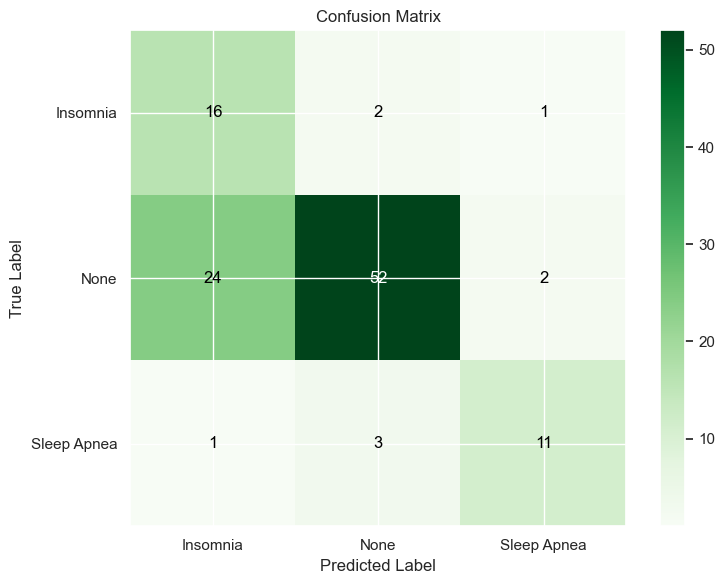

In [65]:
# Get the best estimator from the grid search
best_estimator = gridLG.best_estimator_

# Predict the labels on the test set
y_pred = best_estimator.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
plt.title('Confusion Matrix')
plt.colorbar()
classes = np.unique(y_test)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             ha="center", va="center",
             color="white" if cm[i, j] > thresh else "black")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

###**4.2 Support Vector Machine**

In [66]:
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

with tf.device(device_name):
    param_grid = {
        'C': [1, 10, 100, 1000],
        'gamma': [1, 0.1, 0.01, 0.001],
        'kernel': ['rbf'],
        'class_weight': ['balanced']
    }

    # Adding class_weight='balanced' to SVC
    gridSVM = GridSearchCV(SVC(), param_grid, refit=True, verbose=3, cv=2)
    
    # Fitting the model for grid search
    gridSVM.fit(X_train, y_train)

No GPU, using /device:CPU:0.
Fitting 2 folds for each of 16 candidates, totalling 32 fits
[CV 1/2] END C=1, class_weight=balanced, gamma=1, kernel=rbf;, score=0.906 total time=   0.0s
[CV 2/2] END C=1, class_weight=balanced, gamma=1, kernel=rbf;, score=0.906 total time=   0.0s
[CV 1/2] END C=1, class_weight=balanced, gamma=0.1, kernel=rbf;, score=0.906 total time=   0.0s
[CV 2/2] END C=1, class_weight=balanced, gamma=0.1, kernel=rbf;, score=0.906 total time=   0.0s
[CV 1/2] END C=1, class_weight=balanced, gamma=0.01, kernel=rbf;, score=0.888 total time=   0.0s
[CV 2/2] END C=1, class_weight=balanced, gamma=0.01, kernel=rbf;, score=0.942 total time=   0.0s
[CV 1/2] END C=1, class_weight=balanced, gamma=0.001, kernel=rbf;, score=0.866 total time=   0.0s
[CV 2/2] END C=1, class_weight=balanced, gamma=0.001, kernel=rbf;, score=0.937 total time=   0.0s
[CV 1/2] END C=10, class_weight=balanced, gamma=1, kernel=rbf;, score=0.906 total time=   0.0s
[CV 2/2] END C=10, class_weight=balanced, gam

In [67]:
print(gridSVM.best_params_)

{'C': 1, 'class_weight': 'balanced', 'gamma': 0.01, 'kernel': 'rbf'}


In [68]:
y_pred_test = gridSVM.predict(X_test)
y_pred_train = gridSVM.predict(X_train)

Overfitting checking:

In [69]:
print(accuracy_score(y_train, y_pred_train))
print(accuracy_score(y_test, y_pred_test))

0.9395973154362416
0.8928571428571429


There is no Overfitting, and the model results are good.

**The model predicts sleep disorder with a high accuracy of 89.2%.**

Model metrics:

In [70]:
resultsSVM = train_evaluate_model(y_test)
resultsSVM.index = ['Support Vector Machine']
results = pd.concat([results, resultsSVM])

In [71]:
results.style.background_gradient(cmap = sns.color_palette("blend:red,green", as_cmap=True))

,accuracy,f1_score,precision,recall,balanced_accuracy,auc
Logistic Regression,0.705357,0.728585,0.806770,0.705357,0.747368,0.776598
Support Vector Machine,0.892857,0.887197,0.889834,0.892857,0.783266,0.889280


Confusion Matrix

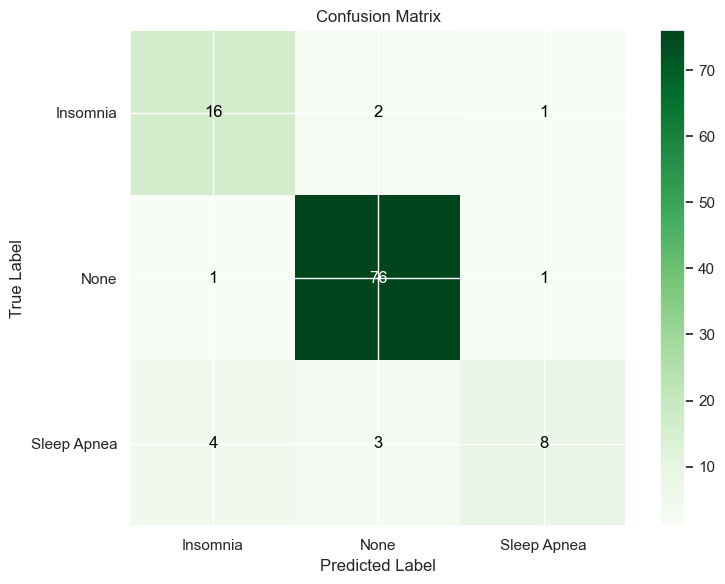

In [72]:
# Get the best estimator from the grid search
best_estimator = gridSVM.best_estimator_

# Predict the labels on the test set
y_pred = best_estimator.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
plt.title('Confusion Matrix')
plt.colorbar()
classes = np.unique(y_test)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             ha="center", va="center",
             color="white" if cm[i, j] > thresh else "black")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

###**4.3 Decision Tree**

In [73]:
dt = DecisionTreeClassifier(random_state=42)
dt = dt.fit(X_train, y_train)

# defining parameter range
param_grid = {'max_depth':range(1, dt.tree_.max_depth+1, 2),
              'max_features': range(1, len(dt.feature_importances_)+1),
              'class_weight':['balanced']}  
gridDT = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, n_jobs=-1)

# fitting the model for grid search
gridDT.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': ['balanced'],
                         'max_depth': range(1, 9, 2),
                         'max_features': range(1, 8)})

In [74]:
print(gridDT.best_params_)

{'class_weight': 'balanced', 'max_depth': 5, 'max_features': 3}


In [75]:
y_pred_test = gridDT.predict(X_test)
y_pred_train = gridDT.predict(X_train)

Overfitting Checking:

In [76]:
print(accuracy_score(y_train, y_pred_train))
print(accuracy_score(y_test, y_pred_test))

0.9351230425055929
0.875


There is Slight Overfitting, but the model results are good.

**The model predicts sleep disorder with a high accuracy of 87.5%.**

Model metrics:

In [77]:
resultsDT = train_evaluate_model(y_test)
resultsDT.index = ['Decision Trees']
results = pd.concat([results, resultsDT])

In [78]:
results.style.background_gradient(cmap = sns.color_palette("blend:red,green", as_cmap=True))

,accuracy,f1_score,precision,recall,balanced_accuracy,auc
Logistic Regression,0.705357,0.728585,0.806770,0.705357,0.747368,0.776598
Support Vector Machine,0.892857,0.887197,0.889834,0.892857,0.783266,0.889280
Decision Trees,0.875000,0.871585,0.870888,0.875000,0.774719,0.878970


Confusion Matrix

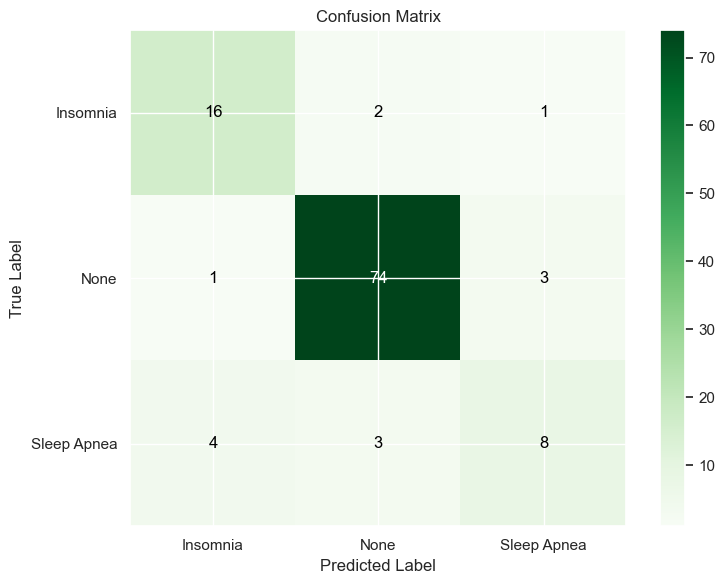

In [79]:
best_estimator = gridDT.best_estimator_

# Predict the labels on the test set
y_pred = best_estimator.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
plt.title('Confusion Matrix')
plt.colorbar()
classes = np.unique(y_test)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             ha="center", va="center",
             color="white" if cm[i, j] > thresh else "black")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

###**4.4 Random Forest**

In [80]:
# Initialize the RandomForestClassifier with computed class weights
RF = RandomForestClassifier()

# Defining parameter grid with the provided hyperparameters
param_grid = {
    'n_estimators': [15, 20, 30, 40, 50, 100, 150, 200, 300, 400],  # Number of trees in the forest
    'max_depth': [3],                                                # Maximum depth of the trees
    'min_samples_split': [6],                                         # Minimum samples required to split an internal node
    'min_samples_leaf': [4],                                          # Minimum samples required to be at a leaf node
    'max_features': ['sqrt'],                                         # Number of features to consider for the best split
    'random_state': [42],                                             # Seed used by the random number generator
    'class_weight': ['balanced'],                                     # Use balanced class weights
}

# Initialize the GridSearchCV object
gridRF = GridSearchCV(RF, param_grid, cv=5, verbose=3, n_jobs=-1)

# Fitting the model with the training data
gridRF.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'max_depth': [3],
                         'max_features': ['sqrt'], 'min_samples_leaf': [4],
                         'min_samples_split': [6],
                         'n_estimators': [15, 20, 30, 40, 50, 100, 150, 200,
                                          300, 400],
                         'random_state': [42]},
             verbose=3)

In [81]:
print(gridRF.best_params_)

{'class_weight': 'balanced', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 15, 'random_state': 42}


In [82]:
y_pred_test = gridRF.predict(X_test)
y_pred_train = gridRF.predict(X_train)

Overfitting Checking:

In [83]:
print(accuracy_score(y_train, y_pred_train))
print(accuracy_score(y_test, y_pred_test))

0.9172259507829977
0.8392857142857143


There is overfitting, the model results are good.

**The model predicts sleep disorder with a good accuracy of 83.9%.**

In [84]:
resultsRF = train_evaluate_model(y_test)
resultsRF.index = ['Random Forest']
results = pd.concat([results, resultsRF])

In [85]:
results.style.background_gradient(cmap = sns.color_palette("blend:red,green", as_cmap=True))

,accuracy,f1_score,precision,recall,balanced_accuracy,auc
Logistic Regression,0.705357,0.728585,0.806770,0.705357,0.747368,0.776598
Support Vector Machine,0.892857,0.887197,0.889834,0.892857,0.783266,0.889280
Decision Trees,0.875000,0.871585,0.870888,0.875000,0.774719,0.878970
Random Forest,0.839286,0.839865,0.843665,0.839286,0.744354,0.857687


Confusion Matrix

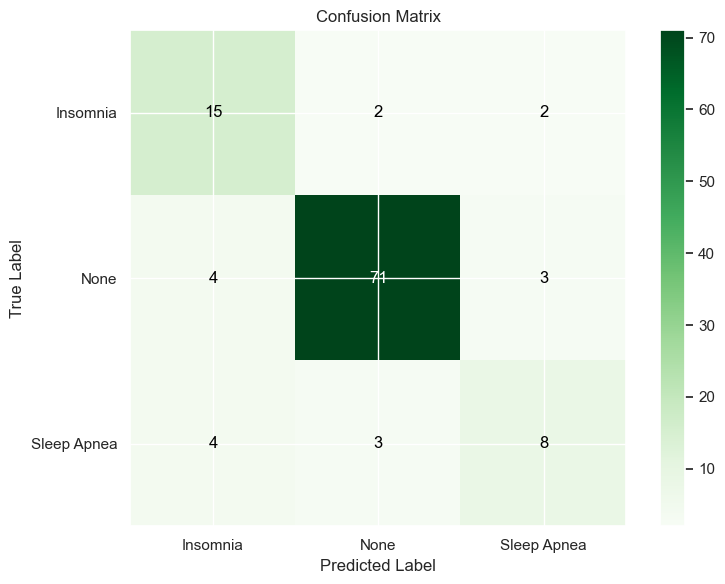

In [86]:
# Get the best estimator from the grid search
best_estimator = gridRF.best_estimator_

# Predict the labels on the test set
y_pred = best_estimator.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
plt.title('Confusion Matrix')
plt.colorbar()
classes = np.unique(y_test)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             ha="center", va="center",
             color="white" if cm[i, j] > thresh else "black")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

###**4.5 Extra Trees**

In [87]:
# Initialize the ExtraTreesClassifier with computed class weights
EF = ExtraTreesClassifier()

# Expanded parameter grid
param_grid = {
    'n_estimators': [15, 20, 30, 40, 50, 100, 150, 200, 300, 400],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False],
    'random_state': [42],
    'class_weight': ['balanced']
}

# Initialize the GridSearchCV object
gridEF = GridSearchCV(EF, param_grid)

# Fitting the model with the training data
gridEF.fit(X_train, y_train)

GridSearchCV(estimator=ExtraTreesClassifier(),
             param_grid={'bootstrap': [True, False],
                         'class_weight': ['balanced'],
                         'max_depth': [3, 5, 10, None],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [15, 20, 30, 40, 50, 100, 150, 200,
                                          300, 400],
                         'random_state': [42]})

In [88]:
print(gridEF.best_params_)

{'bootstrap': False, 'class_weight': 'balanced', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50, 'random_state': 42}


In [89]:
y_pred_test = gridEF.predict(X_test)
y_pred_train = gridEF.predict(X_train)

Overfitting Checking:

In [90]:
print(accuracy_score(y_train, y_pred_train))
print(accuracy_score(y_test, y_pred_test))

0.9328859060402684
0.8839285714285714


There is Moderate Overfitting, the model results are good.

**The model predicts sleep disorder with a high accuracy of 88.3%.**

Model metrics:

In [91]:
resultsEF = train_evaluate_model(y_test)
resultsEF.index = ['Extra Trees']
results = pd.concat([results, resultsEF])

In [92]:
results.style.background_gradient(cmap = sns.color_palette("blend:red,green", as_cmap=True))

,accuracy,f1_score,precision,recall,balanced_accuracy,auc
Logistic Regression,0.705357,0.728585,0.806770,0.705357,0.747368,0.776598
Support Vector Machine,0.892857,0.887197,0.889834,0.892857,0.783266,0.889280
Decision Trees,0.875000,0.871585,0.870888,0.875000,0.774719,0.878970
Random Forest,0.839286,0.839865,0.843665,0.839286,0.744354,0.857687
Extra Trees,0.883929,0.879285,0.883421,0.883929,0.778992,0.883903


Confusion Matrix:

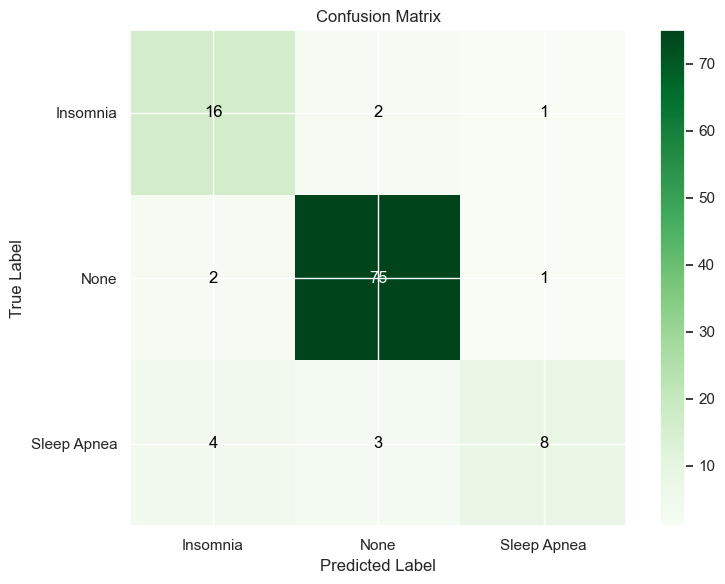

In [93]:
# Get the best estimator from the grid search
best_estimator = gridEF.best_estimator_

# Predict the labels on the test set
y_pred = best_estimator.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
plt.title('Confusion Matrix')
plt.colorbar()
classes = np.unique(y_test)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             ha="center", va="center",
             color="white" if cm[i, j] > thresh else "black")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

###**4.6 Gradient Boosting**

In [94]:
# Expanded parameter grid
param_grid = {
    'n_estimators': [100, 200, 400, 600],          # Number of boosting stages to be run
    'learning_rate': [0.8, 0.5, 0.1, 0.01],        # Step size shrinkage to prevent overfitting
    'max_depth': [3, 5, 7],                        # Maximum depth of individual estimators
    'min_samples_split': [2, 5, 10],              # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],                # Minimum samples required to be at a leaf node
    'subsample': [0.5, 0.7, 1.0],                 # Fraction of samples used for fitting the individual base learners
    'max_features': [None, 'sqrt', 'log2', 4]    # Number of features to consider when looking for the best split
}

# Define the GradientBoostingClassifier with fixed parameters
gridGB = GridSearchCV(
    GradientBoostingClassifier(random_state=42), 
    param_grid=param_grid, 
    scoring='accuracy',
    n_jobs=-1
)

# Fitting the model for grid search with balanced class weights using sample_weight
gridGB.fit(X_train, y_train, sample_weight=compute_sample_weight(class_weight='balanced', y=y_train))

GridSearchCV(estimator=GradientBoostingClassifier(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.8, 0.5, 0.1, 0.01],
                         'max_depth': [3, 5, 7],
                         'max_features': [None, 'sqrt', 'log2', 4],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 400, 600],
                         'subsample': [0.5, 0.7, 1.0]},
             scoring='accuracy')

In [95]:
print(gridGB.best_params_)

{'learning_rate': 0.01, 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 0.5}


In [96]:
y_pred_test = gridGB.predict(X_test)
y_pred_train = gridGB.predict(X_train)

Overfitting Checking:

In [97]:
print(accuracy_score(y_train, y_pred_train))
print(accuracy_score(y_test, y_pred_test))

0.9373601789709173
0.8839285714285714


There is Slight Overfitting, the model results are good.

**The model predicts sleep disorder with a high accuracy of 88.3%.**

Model metrics:

In [98]:
resultsGB = train_evaluate_model(y_test)
resultsGB.index = ['Gradient Boosting']
results = pd.concat([results, resultsGB])

In [99]:
results.style.background_gradient(cmap = sns.color_palette("blend:red,green", as_cmap=True))

,accuracy,f1_score,precision,recall,balanced_accuracy,auc
Logistic Regression,0.705357,0.728585,0.806770,0.705357,0.747368,0.776598
Support Vector Machine,0.892857,0.887197,0.889834,0.892857,0.783266,0.889280
Decision Trees,0.875000,0.871585,0.870888,0.875000,0.774719,0.878970
Random Forest,0.839286,0.839865,0.843665,0.839286,0.744354,0.857687
Extra Trees,0.883929,0.879285,0.883421,0.883929,0.778992,0.883903
Gradient Boosting,0.883929,0.878680,0.878074,0.883929,0.765722,0.884125


Confusion Matrix:

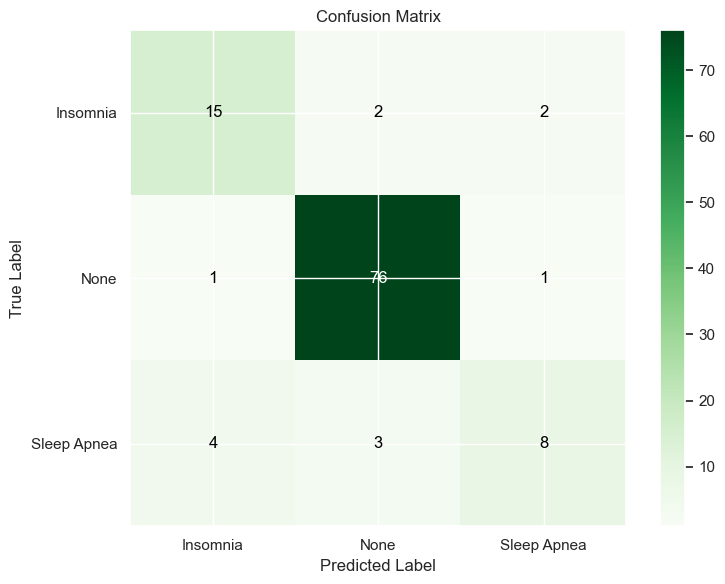

In [100]:
# Get the best estimator from the grid search
best_estimator = gridGB.best_estimator_

# Predict the labels on the test set
y_pred = best_estimator.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
plt.title('Confusion Matrix')
plt.colorbar()
classes = np.unique(y_test)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             ha="center", va="center",
             color="white" if cm[i, j] > thresh else "black")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

###**4.7 Ada Boost**

In [101]:
# Define the parameter grid with the correct structure
param_grid = {
    'n_estimators': [50, 100, 200, 400],                # Number of boosting stages
    'learning_rate': [1, 0.8, 0.5, 0.1, 0.01],         # Shrinks the contribution of each classifier
    'estimator__max_depth': [1, 3, 5, 7],              # Maximum depth of the individual estimators
    'estimator__min_samples_split': [2, 5, 10],        # Minimum samples required to split an internal node
    'estimator__min_samples_leaf': [1, 2, 4],          # Minimum samples required to be at a leaf node
    'estimator__max_features': [None, 'sqrt', 4]       # Features to consider for the best split
}

# Define AdaBoost with a DecisionTreeClassifier as the base estimator
AB = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(random_state=42,class_weight='balanced'),
    random_state=42
)

# Initialize GridSearchCV with the corrected grid
gridAB = GridSearchCV(
    AB,
    param_grid=param_grid,
    scoring='accuracy',
    n_jobs=-1
)

# Fitting the model for grid search
gridAB.fit(X_train, y_train)

GridSearchCV(estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                           random_state=42),
                                          random_state=42),
             n_jobs=-1,
             param_grid={'estimator__max_depth': [1, 3, 5, 7],
                         'estimator__max_features': [None, 'sqrt', 4],
                         'estimator__min_samples_leaf': [1, 2, 4],
                         'estimator__min_samples_split': [2, 5, 10],
                         'learning_rate': [1, 0.8, 0.5, 0.1, 0.01],
                         'n_estimators': [50, 100, 200, 400]},
             scoring='accuracy')

In [102]:
print(gridAB.best_params_)

{'estimator__max_depth': 3, 'estimator__max_features': 4, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 5, 'learning_rate': 0.01, 'n_estimators': 50}


In [103]:
y_pred_test = gridAB.predict(X_test)
y_pred_train = gridAB.predict(X_train)

Overfitting Checking:

In [104]:
print(accuracy_score(y_train, y_pred_train))
print(accuracy_score(y_test, y_pred_test))

0.9395973154362416
0.8928571428571429


There is Slight overfitting, the model results are good.

**The model predicts Sleep Disorder with a high accuracy of 89.2%.**

Model metrics:

In [105]:
resultsAB = train_evaluate_model(y_test)
resultsAB.index = ['Ada Boost']
results = pd.concat([results, resultsAB])

In [106]:
results.style.background_gradient(cmap = sns.color_palette("blend:red,green", as_cmap=True))

,accuracy,f1_score,precision,recall,balanced_accuracy,auc
Logistic Regression,0.705357,0.728585,0.806770,0.705357,0.747368,0.776598
Support Vector Machine,0.892857,0.887197,0.889834,0.892857,0.783266,0.889280
Decision Trees,0.875000,0.871585,0.870888,0.875000,0.774719,0.878970
Random Forest,0.839286,0.839865,0.843665,0.839286,0.744354,0.857687
Extra Trees,0.883929,0.879285,0.883421,0.883929,0.778992,0.883903
Gradient Boosting,0.883929,0.878680,0.878074,0.883929,0.765722,0.884125
Ada Boost,0.892857,0.887197,0.889834,0.892857,0.783266,0.889280


Confusion Matrix

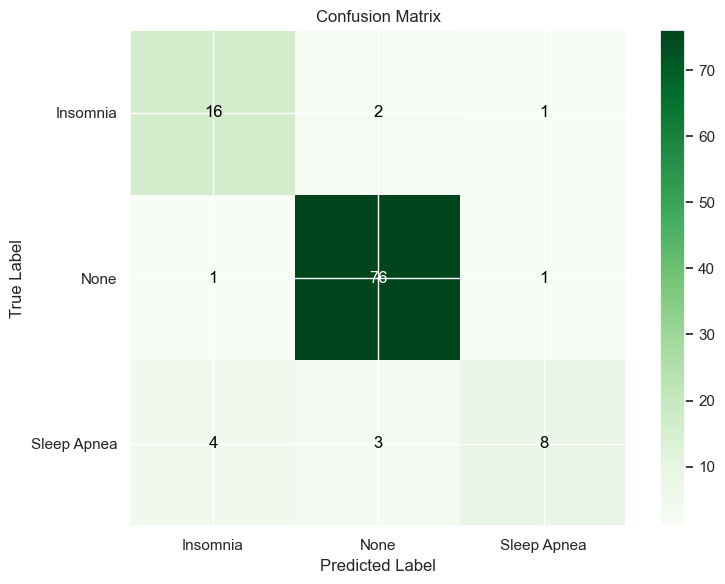

In [107]:
# Get the best estimator from the grid search
best_estimator = gridAB.best_estimator_

# Predict the labels on the test set
y_pred = best_estimator.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
plt.title('Confusion Matrix')
plt.colorbar()
classes = np.unique(y_test)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             ha="center", va="center",
             color="white" if cm[i, j] > thresh else "black")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

###**4.8 Stacking Voting**

In [185]:
# Create the SVC model with the best parameters and probability =  True to avoid errors
NSVM = SVC(C=1, class_weight='balanced', gamma=0.01, kernel='rbf', probability=True, random_state=42) 
NSVM.fit(X_train, y_train)

# The combined model--Decision Trees and Random Forest
estimators = [('Ada Boost', gridAB), ('Support Vector Machine', NSVM)]
VC = VotingClassifier(estimators, voting='soft')
VC = VC.fit(X_train, y_train)

In [186]:
y_pred_test = VC.predict(X_test)
y_pred_train = VC.predict(X_train)

Overfitting Checking:

In [187]:
print(accuracy_score(y_train, y_pred_train))
print(accuracy_score(y_test, y_pred_test))

0.9395973154362416
0.8928571428571429


There is no overfitting, the model results are good.

**The model predicts sleep disorder with a high accuracy of 91%.**

Model metrics:

In [188]:
resultsVC = train_evaluate_model(y_test)
resultsVC.index = ['Stacking Voting']
results = pd.concat([results, resultsVC])

In [189]:
results.style.background_gradient(cmap = sns.color_palette("blend:red,green", as_cmap=True))

,accuracy,f1_score,precision,recall,balanced_accuracy,auc
Logistic Regression,0.705357,0.728585,0.806770,0.705357,0.747368,0.776598
Support Vector Machine,0.892857,0.887197,0.889834,0.892857,0.783266,0.889280
Decision Trees,0.875000,0.871585,0.870888,0.875000,0.774719,0.878970
Random Forest,0.839286,0.839865,0.843665,0.839286,0.744354,0.857687
Extra Trees,0.883929,0.879285,0.883421,0.883929,0.778992,0.883903
Gradient Boosting,0.883929,0.878680,0.878074,0.883929,0.765722,0.884125
Ada Boost,0.892857,0.887197,0.889834,0.892857,0.783266,0.889280
K Nearest Neighbors,0.875000,0.871585,0.870888,0.875000,0.774719,0.878970
Naive Bayes,0.812500,0.815567,0.834003,0.812500,0.713585,0.841114
Stacking Voting,0.892857,0.887197,0.889834,0.892857,0.783266,0.889280


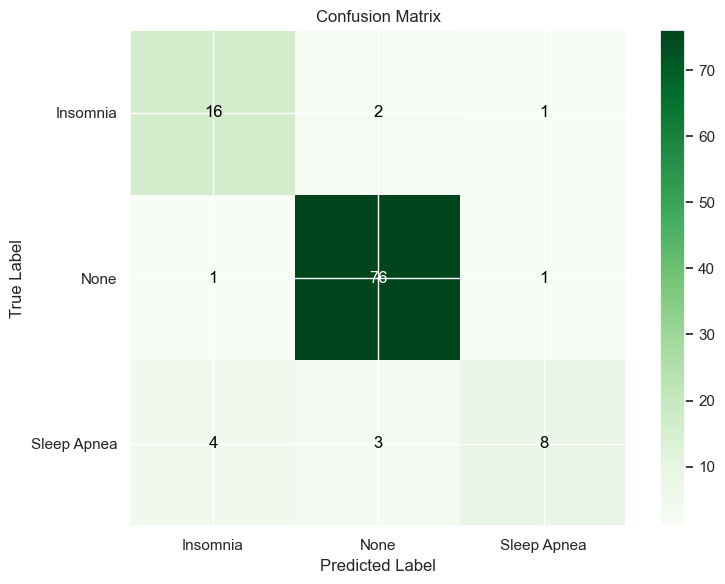

In [190]:
# Get the best estimator from the grid search
best_estimator = VC

# Predict the labels on the test set
y_pred = best_estimator.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
plt.title('Confusion Matrix')
plt.colorbar()
classes = np.unique(y_test)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             ha="center", va="center",
             color="white" if cm[i, j] > thresh else "black")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

**Sampling for the models that dont have the class_weight = balanced hyperparameter**

In [109]:
# Apply SMOTE to oversample the training set (X_train, y_train)
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

###**4.9 K Nearest Neighbors**

In [110]:
# defining parameter range
param_grid = {'n_neighbors': [1,3,5,7,9,11,13,15,17,19],  #odd numbers because there are 2 classes in target coulmn
              'weights': ['distance', 'uniform']}  
gridKNN = GridSearchCV(KNeighborsClassifier(), param_grid, refit = True, verbose = 3)
  
# fitting the model for grid search
gridKNN.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ...n_neighbors=1, weights=distance;, score=0.771 total time=   0.0s
[CV 2/5] END ...n_neighbors=1, weights=distance;, score=0.882 total time=   0.0s
[CV 3/5] END ...n_neighbors=1, weights=distance;, score=0.831 total time=   0.0s
[CV 4/5] END ...n_neighbors=1, weights=distance;, score=0.837 total time=   0.0s
[CV 5/5] END ...n_neighbors=1, weights=distance;, score=0.848 total time=   0.0s
[CV 1/5] END ....n_neighbors=1, weights=uniform;, score=0.771 total time=   0.0s
[CV 2/5] END ....n_neighbors=1, weights=uniform;, score=0.882 total time=   0.0s
[CV 3/5] END ....n_neighbors=1, weights=uniform;, score=0.831 total time=   0.0s
[CV 4/5] END ....n_neighbors=1, weights=uniform;, score=0.837 total time=   0.0s
[CV 5/5] END ....n_neighbors=1, weights=uniform;, score=0.848 total time=   0.0s
[CV 1/5] END ...n_neighbors=3, weights=distance;, score=0.899 total time=   0.0s
[CV 2/5] END ...n_neighbors=3, weights=distance

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
                         'weights': ['distance', 'uniform']},
             verbose=3)

In [111]:
print(gridKNN.best_params_)

{'n_neighbors': 3, 'weights': 'distance'}


In [112]:
y_pred_test = gridKNN.predict(X_test)
y_pred_train = gridKNN.predict(X_train)

Overfitting checking:

In [113]:
print(accuracy_score(y_train, y_pred_train))
print(accuracy_score(y_test, y_pred_test))

0.9629629629629629
0.875


There is overfitting but the model results are good.

**The model predicts sleep disorder with a high accuracy of 87.5%.**

In [114]:
resultsKNN = train_evaluate_model(y_test)
resultsKNN.index = ['K Nearest Neighbors']
results = pd.concat([results, resultsKNN])

In [115]:
results.style.background_gradient(cmap = sns.color_palette("blend:red,green", as_cmap=True))

,accuracy,f1_score,precision,recall,balanced_accuracy,auc
Logistic Regression,0.705357,0.728585,0.806770,0.705357,0.747368,0.776598
Support Vector Machine,0.892857,0.887197,0.889834,0.892857,0.783266,0.889280
Decision Trees,0.875000,0.871585,0.870888,0.875000,0.774719,0.878970
Random Forest,0.839286,0.839865,0.843665,0.839286,0.744354,0.857687
Extra Trees,0.883929,0.879285,0.883421,0.883929,0.778992,0.883903
Gradient Boosting,0.883929,0.878680,0.878074,0.883929,0.765722,0.884125
Ada Boost,0.892857,0.887197,0.889834,0.892857,0.783266,0.889280
K Nearest Neighbors,0.875000,0.871585,0.870888,0.875000,0.774719,0.878970


Confusion Matrix

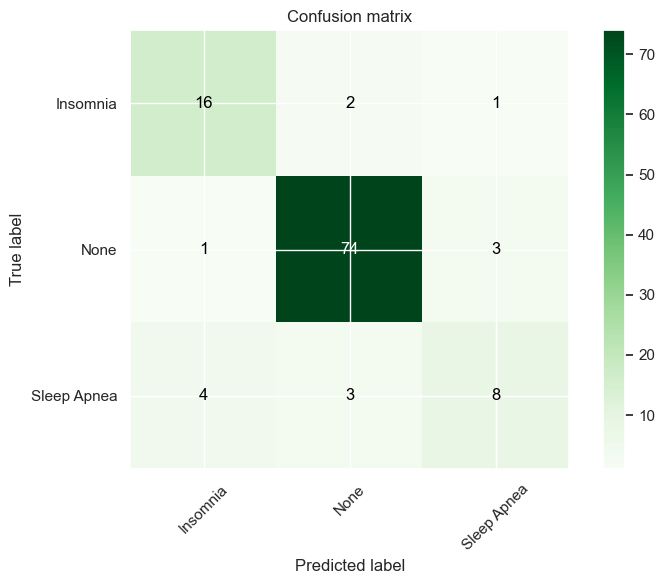

In [116]:
# Assuming gridKNN is your GridSearchCV object
best_estimator = gridKNN.best_estimator_

# Get predictions on test data
y_pred = best_estimator.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Set the figure size
plt.figure(figsize=(8, 6))

# Plot confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
plt.title('Confusion matrix')
plt.colorbar()
classes = np.unique(y_test)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             ha="center", va="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

###**4.10 Naive Bayes**

In [117]:
cv_N = 10
nb = {'gaussian': GaussianNB(),
      'bernoulli': BernoulliNB()
      }
scores = {}
for key, model in nb.items():
    s = cross_val_score(model, X_train, y_train, cv=cv_N, n_jobs=cv_N, scoring='accuracy')
    scores[key] = np.mean(s)
scores

{'gaussian': 0.8732584269662922, 'bernoulli': 0.49485642946317104}

In [118]:
# fitting the model
GNB = GaussianNB()
GNB.fit(X_train, y_train)

GaussianNB()

Prediction according to this model.

In [119]:
y_pred_test = GNB.predict(X_test)
y_pred_train = GNB.predict(X_train)

In [120]:
print(accuracy_score(y_train, y_pred_train))
print(accuracy_score(y_test, y_pred_test))

0.8742985409652076
0.8125


There is overfitting, but the model results are ok.

The model metrics:

**The model predicts sleep disorder with a low accuracy of 81.25%.**

In [121]:
resultsNB = train_evaluate_model(y_test)
resultsNB.index = ['Naive Bayes']
results = pd.concat([results, resultsNB])

In [122]:
results.style.background_gradient(cmap = sns.color_palette("blend:red,green", as_cmap=True))

,accuracy,f1_score,precision,recall,balanced_accuracy,auc
Logistic Regression,0.705357,0.728585,0.806770,0.705357,0.747368,0.776598
Support Vector Machine,0.892857,0.887197,0.889834,0.892857,0.783266,0.889280
Decision Trees,0.875000,0.871585,0.870888,0.875000,0.774719,0.878970
Random Forest,0.839286,0.839865,0.843665,0.839286,0.744354,0.857687
Extra Trees,0.883929,0.879285,0.883421,0.883929,0.778992,0.883903
Gradient Boosting,0.883929,0.878680,0.878074,0.883929,0.765722,0.884125
Ada Boost,0.892857,0.887197,0.889834,0.892857,0.783266,0.889280
K Nearest Neighbors,0.875000,0.871585,0.870888,0.875000,0.774719,0.878970
Naive Bayes,0.812500,0.815567,0.834003,0.812500,0.713585,0.841114


Confusion Matrix

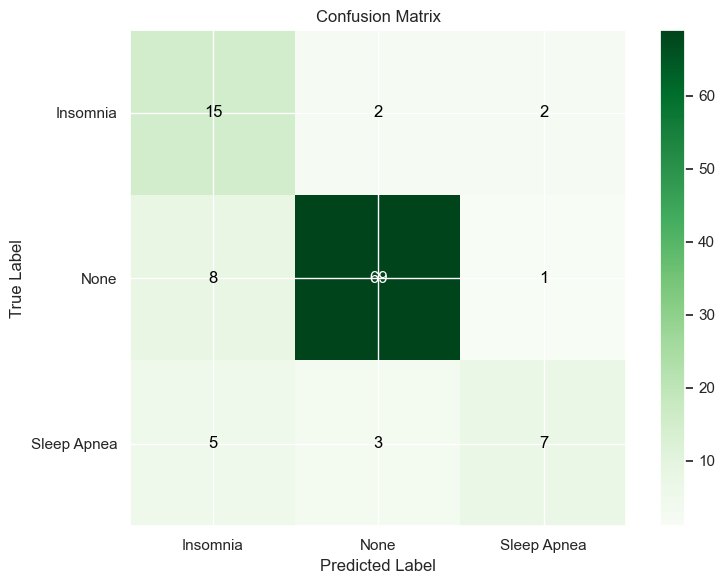

In [123]:
# Get the best estimator from the grid search
best_estimator = GNB

# Predict the labels on the test set
y_pred = best_estimator.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
plt.title('Confusion Matrix')
plt.colorbar()
classes = np.unique(y_test)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             ha="center", va="center",
             color="white" if cm[i, j] > thresh else "black")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

#**5. Summary**

###**5.1 Conclusions & Suggestions For Improvement**

In [191]:
#order the result df by accuracy from high to low.
results.sort_values(results.columns[0], ascending = False)

,accuracy,f1_score,precision,recall,balanced_accuracy,auc
Support Vector Machine,0.892857,0.887197,0.889834,0.892857,0.783266,0.889280
Ada Boost,0.892857,0.887197,0.889834,0.892857,0.783266,0.889280
Stacking Voting,0.892857,0.887197,0.889834,0.892857,0.783266,0.889280
Extra Trees,0.883929,0.879285,0.883421,0.883929,0.778992,0.883903
Gradient Boosting,0.883929,0.878680,0.878074,0.883929,0.765722,0.884125
Decision Trees,0.875000,0.871585,0.870888,0.875000,0.774719,0.878970
K Nearest Neighbors,0.875000,0.871585,0.870888,0.875000,0.774719,0.878970
Random Forest,0.839286,0.839865,0.843665,0.839286,0.744354,0.857687
Naive Bayes,0.812500,0.815567,0.834003,0.812500,0.713585,0.841114
Logistic Regression,0.705357,0.728585,0.806770,0.705357,0.747368,0.776598


**Exporting the Support Vector Machine because its the best Model**

In [192]:
# Specify the full path to save the pickle file
file_path = r'..Webpage\Model\SA_I_SVM.pickle'

# Save the model to a pickle file
with open(file_path, 'wb') as f:
    pickle.dump(gridSVM, f)